In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.model_selection import cross_val_predict, cross_validate, RandomizedSearchCV
from sklearn.model_selection import learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, log_loss
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, AdaBoostClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA

In [ ]:
# @title

import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.utils import shuffle
import scipy
#from scipy.special import softmax
from sklearn.utils import check_random_state
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from numba import jit


@jit(nopython=True)
def my_softmax(x):
  # implementation taken from here: https://github.com/scipy/scipy/blob/v1.10.1/scipy/special/_logsumexp.py#L131-L225
  # implemented by hand to fix NumBa issues
  x_max = np.max(x)
  exp_x_shifted = np.exp(x - x_max)
  return exp_x_shifted / np.sum(exp_x_shifted)


@jit(nopython=True)
def basis_vec(dim, i):
  v = np.zeros(dim)
  v[i] = 1
  return v



@jit(nopython=True)
def do_epoch(A, b, X_, y_, alpha, lam):
  N = X_.shape[0]
  out_dim = A.shape[0]

  for i in range(N):
    logit = A @ X_[i] + b
    probas = my_softmax(logit)

    w = probas - basis_vec(out_dim, y_[i])

    A *= (1. - 2 * alpha * lam)
    A -= lam * np.outer(w, X_[i])

    # don't regularize b
    b -= lam * w

  return (A, b)


class SGDSoftmaxClassifier(BaseEstimator, ClassifierMixin):
  """
  NOTE: The current implementation uses a _constant_ learning rate,
        and does not implement early stopping.
        Maybe this will come later.
  """
  def __init__(self,
               max_iter=1000, # maximal number of epochs
               eta0=0.001,
               tol=0.001,
               early_stopping=False,
               validation_fraction=0.1,
               n_iter_no_change=5,
               learning_rate='constant', # can be 'constant' or 'adaptive'
               alpha=0.0001,
               verbose=0,
               random_state=None):
    self.max_iter = max_iter
    self.eta0 = eta0
    self.tol = tol
    self.early_stopping = early_stopping
    self.validation_fraction = validation_fraction
    self.n_iter_no_change = n_iter_no_change
    self.learning_rate = learning_rate
    self.alpha = alpha
    self.verbose = verbose
    self.random_state = random_state


  def predict_proba(self, X):
    # Check if fit has been called
    check_is_fitted(self)

    # Input validation
    X = check_array(X)

    A = self.coef_
    b = self.intercept_
    logits = np.matmul(X, A.T) + b.reshape((1,-1))
    return scipy.special.softmax(logits, axis=1)


  def predict(self, X):
    p = self.predict_proba(X)
    return self.classes_[np.argmax(p, axis=1)]


  def fit(self, X, y):
      # Check that X and y have correct shape
      X, y = check_X_y(X, y)
      X = X.astype('float') # to fix NumBa issues with different types
      # Store the classes seen during fit
      self.classes_ = unique_labels(y)

      in_dim = X.shape[1]
      out_dim = len(self.classes_)
      N = X.shape[0]

      self.n_features_in_ = in_dim

      indices = np.zeros(N, dtype='int')
      for i, c in enumerate(self.classes_):
        indices[y == c] = i
      y = indices # replace the true labels by indices

      self.random_state_ = check_random_state(self.random_state)

      if self.early_stopping:
        X, X_val, y, y_val = train_test_split(X, y,
                                              test_size=self.validation_fraction,
                                              stratify=y,
                                              random_state=self.random_state_)

      A = np.zeros((out_dim,in_dim)) # start at zero. Maybe we should initialize randomly?
      b = np.zeros((out_dim)) # start at zero. Maybe we should initialize randomly?
      lam = self.eta0

      best_A = A
      best_b = b
      it_without_improvement = 0
      if self.early_stopping:
        best_score = -np.inf
      else:
        best_loss = np.inf

      for e in range(self.max_iter):
        X_, y_ = shuffle(X, y, random_state=self.random_state_)

        if self.verbose > 0:
          # print the loss after each epoch
          print(f"epoch {e}: STARTING")

        A, b = do_epoch(A, b, X_, y_, self.alpha, lam)

        if self.early_stopping:
          logits = np.matmul(X_val, A.T) + b.reshape((1,-1))
          ps = scipy.special.softmax(logits, axis=1)
          y_pred = np.argmax(ps, axis=1)
          score = accuracy_score(y_val, y_pred)

          if score >= best_score + self.tol:
            it_without_improvement = 0
          else:
            it_without_improvement += 1

          if score > best_score:
            best_A = A.copy()
            best_b = b.copy()
            best_score = score

        else:
          logits = np.matmul(X_, A.T) + b.reshape((1,-1))
          ps = scipy.special.softmax(logits, axis=1)
          if out_dim <= 1:
            loss = 0
          else:
            loss = log_loss(y_, ps)

          if loss <= best_loss - self.tol:
            it_without_improvement = 0
          else:
            it_without_improvement += 1

          if loss < best_loss:
            best_loss = loss
            best_A = A.copy()
            best_b = b.copy()

        if it_without_improvement >= self.n_iter_no_change:
          it_without_improvement = 0
          if self.learning_rate == 'adaptive':
            lam /= 5
            if self.verbose > 0:
              print("decreasing learning rate (no improvement for too long)")
            if lam < lam / 5**7:
              if self.verbose > 0:
                print("stopping SGD (too small learning rate)")
              break
          else:
            if self.verbose > 0:
              print("stopping SGD (too many iterations without improvement)")
            break # stop after too many iterations without improvement

        if self.verbose > 0:
          # print the loss after each epoch
          print(f"epoch {e}: DONE")
          if self.early_stopping:
            print("Validation loss:", log_loss(y_val, ps))
            print("Validation accuracy:", score)
          else:
            print(f"Train loss:", log_loss(y_, ps))
            y_pred = np.argmax(ps, axis=1)
            print(f"Train accuracy:", accuracy_score(y_, y_pred))

      self.coef_ = best_A
      self.intercept_ = best_b
      self.n_iter_ = e

      # Return the classifier
      return self



#Introduction

---



The following dataset is obtained from the UCI Machine Learning Repository. It has 16 features and a target feature- the English alphabet. 20,000 different samples-where each sample represents a greyscale image of a letter of the alphabet- were put together to create it.
The 16 features describe black-and-white rectangular pixel displays using discrete numeric values.
The goal is to recognize 26 capital letters from numerical descriptions of black-and-white pixel images.
This section loads the dataset into a pandas DataFrame and assigns appropriate column names. However the data does not come with its column names, so I'll manually insert those.
A random sample of 1000 rows is taken for exploratory data analysis.
The features and target variable are then separated into X and y.

In [ ]:
!wget https://archive.ics.uci.edu/static/public/59/letter+recognition.zip
!unzip letter+recognition.zip

!ls

columns = ["letter", "x-box", "y-box", "width", "height",
           "onpix", "x-on-bar", "y-on-bar", "xvar-bar",
           "yvar-bar", "xy-corr-bar", "x2ybar", "xy2bar",
           "xeg-bar", "xegy-corr", "yeg-bar", "yegx-corr"]

data_df = pd.read_csv("letter-recognition.data", names= columns)
data_sample = data_df.sample(1000, random_state=42)

#Splitting features and target
X = data_df.iloc[:, 1:]
y = data_df.iloc[:, 0]

print(data_sample.head())

--2024-07-06 20:19:57--  https://archive.ics.uci.edu/static/public/59/letter+recognition.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘letter+recognition.zip’

letter+recognition.     [  <=>               ] 378.09K  1.24MB/s    in 0.3s    

2024-07-06 20:19:58 (1.24 MB/s) - ‘letter+recognition.zip’ saved [387167]

Archive:  letter+recognition.zip
  inflating: Index                   
  inflating: letter-recognition.data  
  inflating: letter-recognition.data.Z  
  inflating: letter-recognition.names  
Index			 letter-recognition.data.Z  letter+recognition.zip
letter-recognition.data  letter-recognition.names   sample_data
      letter  x-box  y-box  width  height  onpix  x-on-bar  y-on-bar  \
10650      T      3      6      5       6      4         6         7   
2041       L      4     11   

The features in this dataset describe the position of the box containing the pixel display of a letter, the number of on pixels,  number of edges and some statistical features of the aforementioned descriptions. In the plot below, it shows that all of the features have integer values, except the target.

*   x-box: Horizontal position of the box containing the letter.
*   y-box: Vertical position of the box containing the letter.
*   width: Width of the box containing the letter.
*   height: Height of the box containing the letter.
*   onpix: Total number of pixels that are 'on' (i.e., the pigmented pixels in the display).
*   x-on-bar: Mean position of the 'on' pixels horizontally.
*   y-on-bar: Mean position of the 'on' pixels vertically.
*   xvar-bar: Horizontal spread of the 'on' pixels from the horizontal center of gravity.
*   yvar-bar: Vertical spread of the 'on' pixels from the vertical center of gravity.
*   xeg-bar: Mean number of 'on' pixel edges counted from left to right.
*   yeg-bar: Mean number of 'on' pixel edges counted from top to bottom.
*   xy-corr-bar: correlation between x and y positions of 'on' pixels.
*   xegy-corr: Correlation measure involving the number of 'on' pixel edges and y positions.
*   yegx-corr: Correlation measure involving the number of 'on' pixel edges and x positions.
*   letter: The target variable representing the letter (A-Z).

The other 2 features are statiscal moments of some of the other features;
'x2ybar' and 'xy2bar'.





#Exploratory Data Analysis

In [ ]:
#Viewing the type and nature of values we're working with
print(data_df.info())
#Generating descriptive statistics on the features
print(data_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   letter       20000 non-null  object
 1   x-box        20000 non-null  int64 
 2   y-box        20000 non-null  int64 
 3   width        20000 non-null  int64 
 4   height       20000 non-null  int64 
 5   onpix        20000 non-null  int64 
 6   x-on-bar     20000 non-null  int64 
 7   y-on-bar     20000 non-null  int64 
 8   xvar-bar     20000 non-null  int64 
 9   yvar-bar     20000 non-null  int64 
 10  xy-corr-bar  20000 non-null  int64 
 11  x2ybar       20000 non-null  int64 
 12  xy2bar       20000 non-null  int64 
 13  xeg-bar      20000 non-null  int64 
 14  xegy-corr    20000 non-null  int64 
 15  yeg-bar      20000 non-null  int64 
 16  yegx-corr    20000 non-null  int64 
dtypes: int64(16), object(1)
memory usage: 2.6+ MB
None
              x-box         y-box         width       he

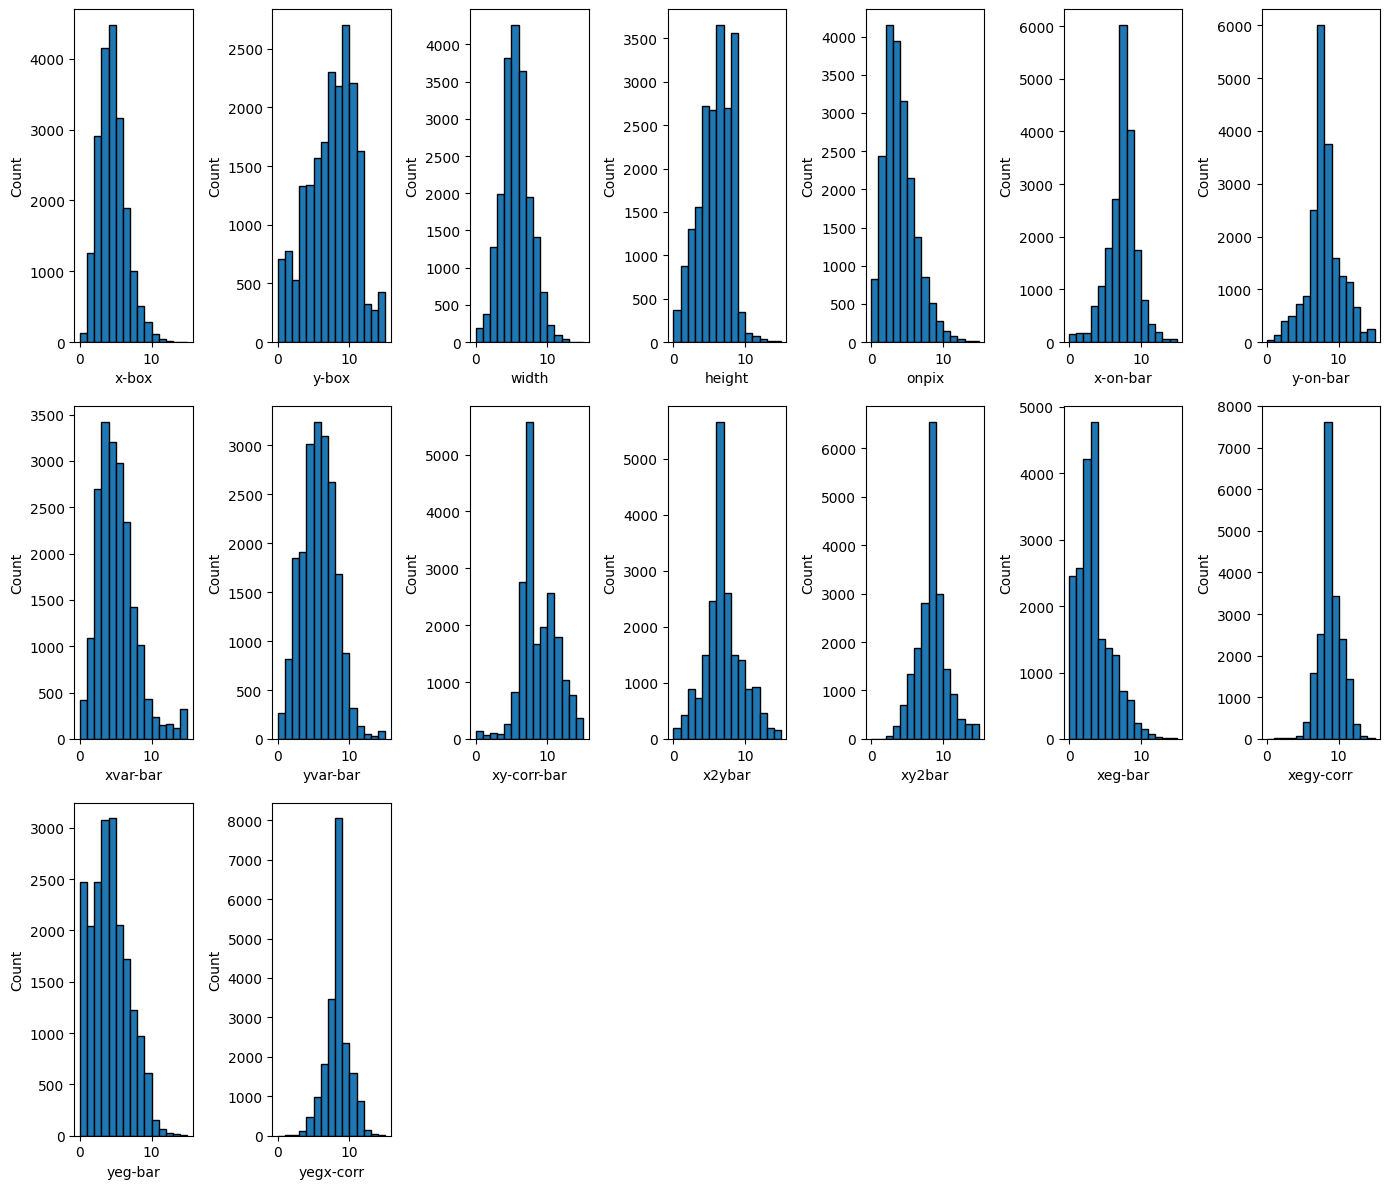

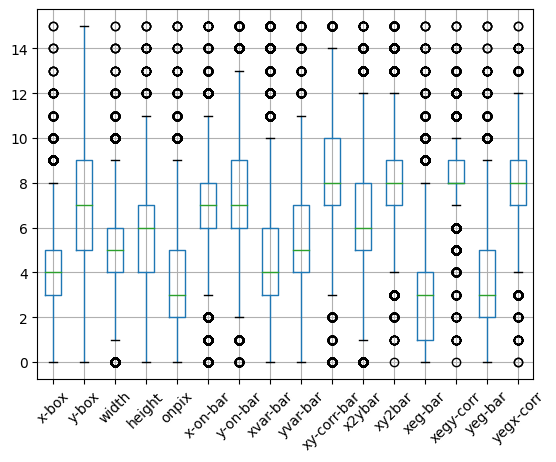

In [ ]:
#Here I'll be looking at the distribution of the numerical data

#plot 1
plt.figure(figsize=(14,12))
for i, column in enumerate(X.columns):
    plt.subplot(3, 7, i+1)
    plt.hist(X[column], bins=15, edgecolor='black')
    plt.xlabel(column)
    plt.ylabel('Count')
plt.tight_layout()
plt.savefig('histograms.png')
plt.show()

#plot 2
data_df.boxplot()
plt.xticks(rotation=45)
plt.savefig('boxplot.png')
plt.show()

The plot clearly displays that the data is already scaled to fit into a range of integer values from 0 through 15.
All features have 20,000 non-null entries, indicating no missing values.
The letter feature contains categorical values representing letters from A to Z.

There seem to be quite a number of outliers for each feature, except y-box.
y-box seems to have a big variance and seems roughly symmetric, which makes sense for letters like 'W'.
I would now want to investigate the relationship of some features and some selected classes.

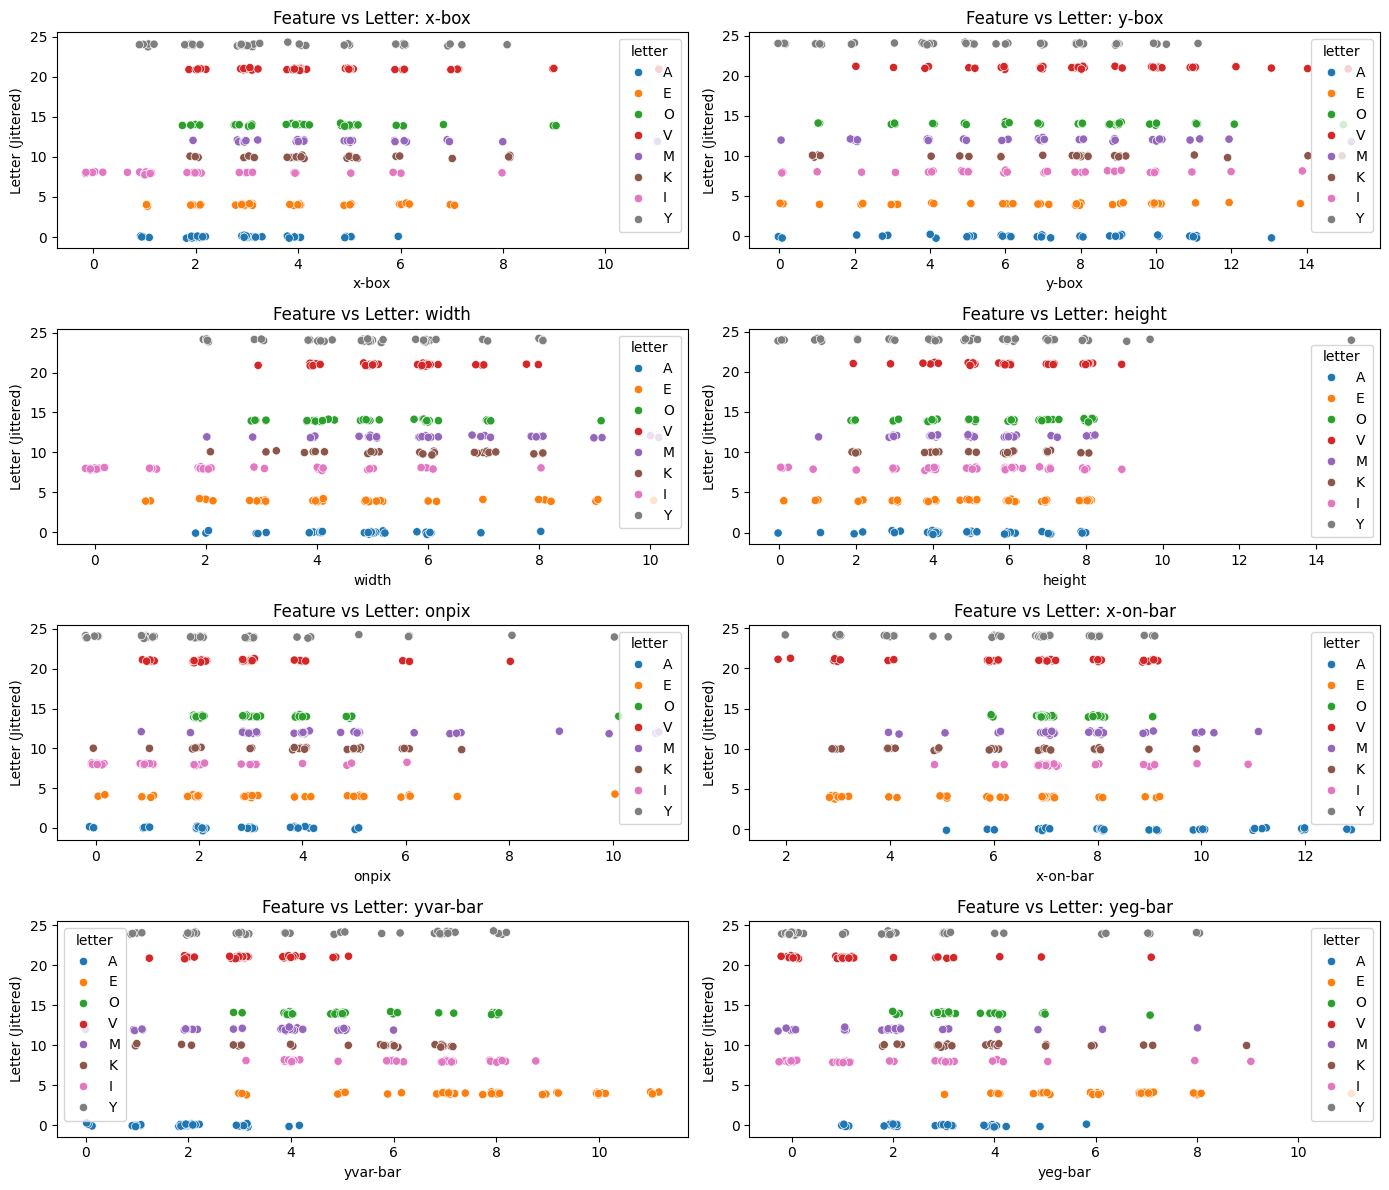

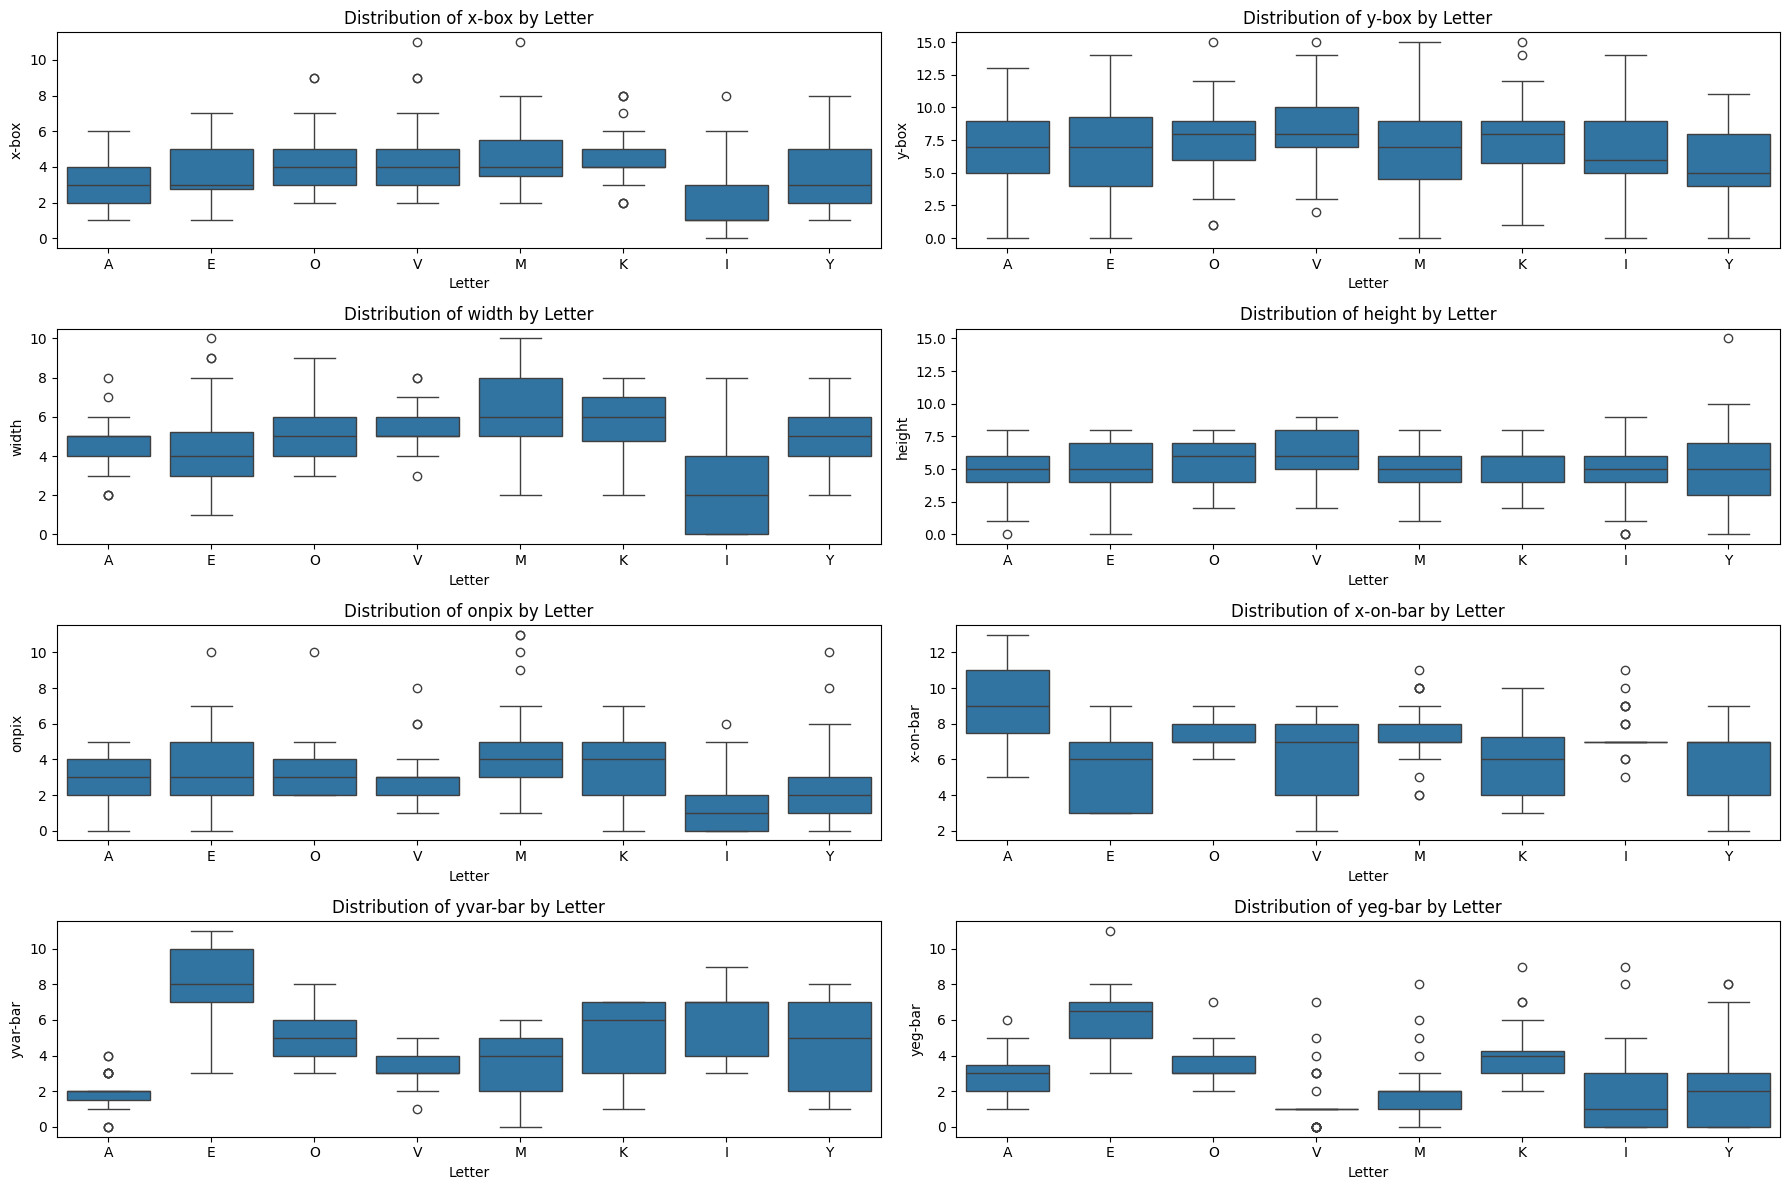

In [ ]:
def add_jitter(data, jitter_amount=0.1):
    return data + np.random.normal(0, jitter_amount, size=data.shape)

features = ['x-box', 'y-box', 'width', 'height', 'onpix', 'x-on-bar', 'yvar-bar', 'yeg-bar']
selected_classes = ['A', 'E', 'I', 'K', 'M', 'O', 'V', 'Y']
data_sample_selected = data_sample[data_sample['letter'].isin(selected_classes)]

plt.figure(figsize=(14, 12))
for i, feature in enumerate(features):
    plt.subplot(4, 2, i + 1)
    jittered_x = add_jitter(data_sample_selected[feature].values)
    jittered_y = add_jitter(data_sample_selected['letter'].apply(lambda x: ord(x) - ord('A')).values)
    sns.scatterplot(x=jittered_x, y=jittered_y, hue=data_sample_selected['letter'])
    plt.xlabel(feature)
    plt.ylabel('Letter (Jittered)')
    plt.title(f'Feature vs Letter: {feature}')
plt.tight_layout()
plt.savefig('scatterplot.png')
plt.show()

plt.figure(figsize=(18, 12))
for i, feature in enumerate(features):
    plt.subplot(4, 2, i + 1)
    sns.boxplot(x='letter', y=feature, data=data_sample_selected)
    plt.xlabel('Letter')
    plt.ylabel(feature)
    plt.title(f'Distribution of {feature} by Letter')
plt.tight_layout()
plt.savefig('boxplot_by_letter.png')
plt.show()

Above we see that letters like 'I' tend to have a smaller width and a smaller number of edges(counting from left to right) than 'M'.  'V' tends to have very small values for yeg-bar. The chosen letters also seem to have similar heights. Considering the boxplot for x-on-bar, 'I' seems to be very centered in the middle, most of its points are around 7. Letters like 'E' seem to be more spread out vertically. 'M" tends to have a bigger width.

Next I'll be checking the distribution of all the classes in the target feature, as a test for imbalance.

 3.94% of the target are of class A
 3.83% of the target are of class B
 3.68% of the target are of class C
 4.03% of the target are of class D
 3.84% of the target are of class E
 3.88% of the target are of class F
 3.86% of the target are of class G
 3.67% of the target are of class H
 3.77% of the target are of class I
 3.74% of the target are of class J
 3.69% of the target are of class K
 3.81% of the target are of class L
 3.96% of the target are of class M
 3.91% of the target are of class N
 3.77% of the target are of class O
 4.01% of the target are of class P
 3.91% of the target are of class Q
 3.79% of the target are of class R
 3.74% of the target are of class S
 3.98% of the target are of class T
 4.06% of the target are of class U
 3.82% of the target are of class V
 3.76% of the target are of class W
 3.94% of the target are of class X
 3.93% of the target are of class Y
 3.67% of the target are of class Z


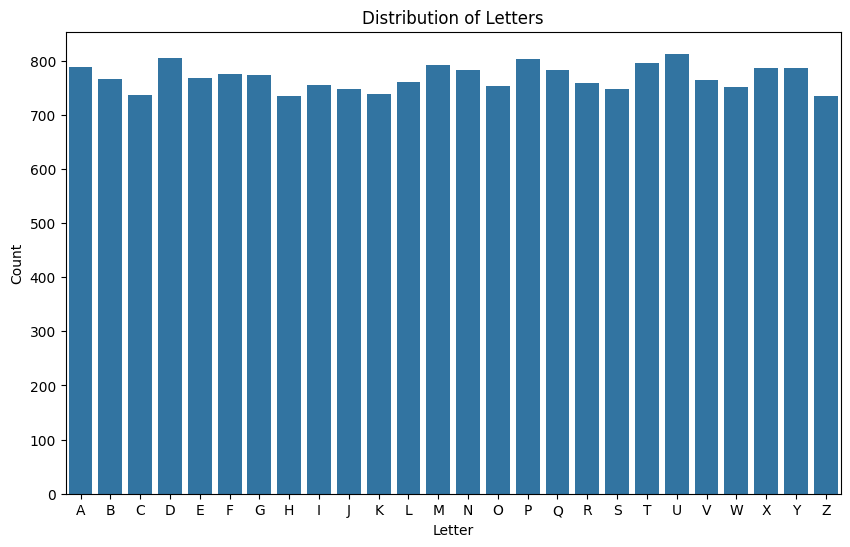

In [ ]:
values, counts = np.unique(y, return_counts=True)
for v, p in zip(values, counts/np.sum(counts)):
    print(f"{100*p:5.2f}% of the target are of class {v}")

plt.figure(figsize=(10, 6))
sns.countplot(x='letter', data=data_df, order=sorted(data_df['letter'].unique()))
plt.title('Distribution of Letters')
plt.xlabel('Letter')
plt.ylabel('Count')
plt.savefig('letter_distribution.png')
plt.show()

The distribution is fairly uniform, with each letter class accounting for around 3.7% to 4.1% of the total dataset.
This balance ensures that no single letter class dominates the dataset, which is beneficial for training models that need to recognize various letters equally well.
With a balanced distribution, models are less likely to be biased towards predicting more frequent classes, leading to more reliable performance across all letters.

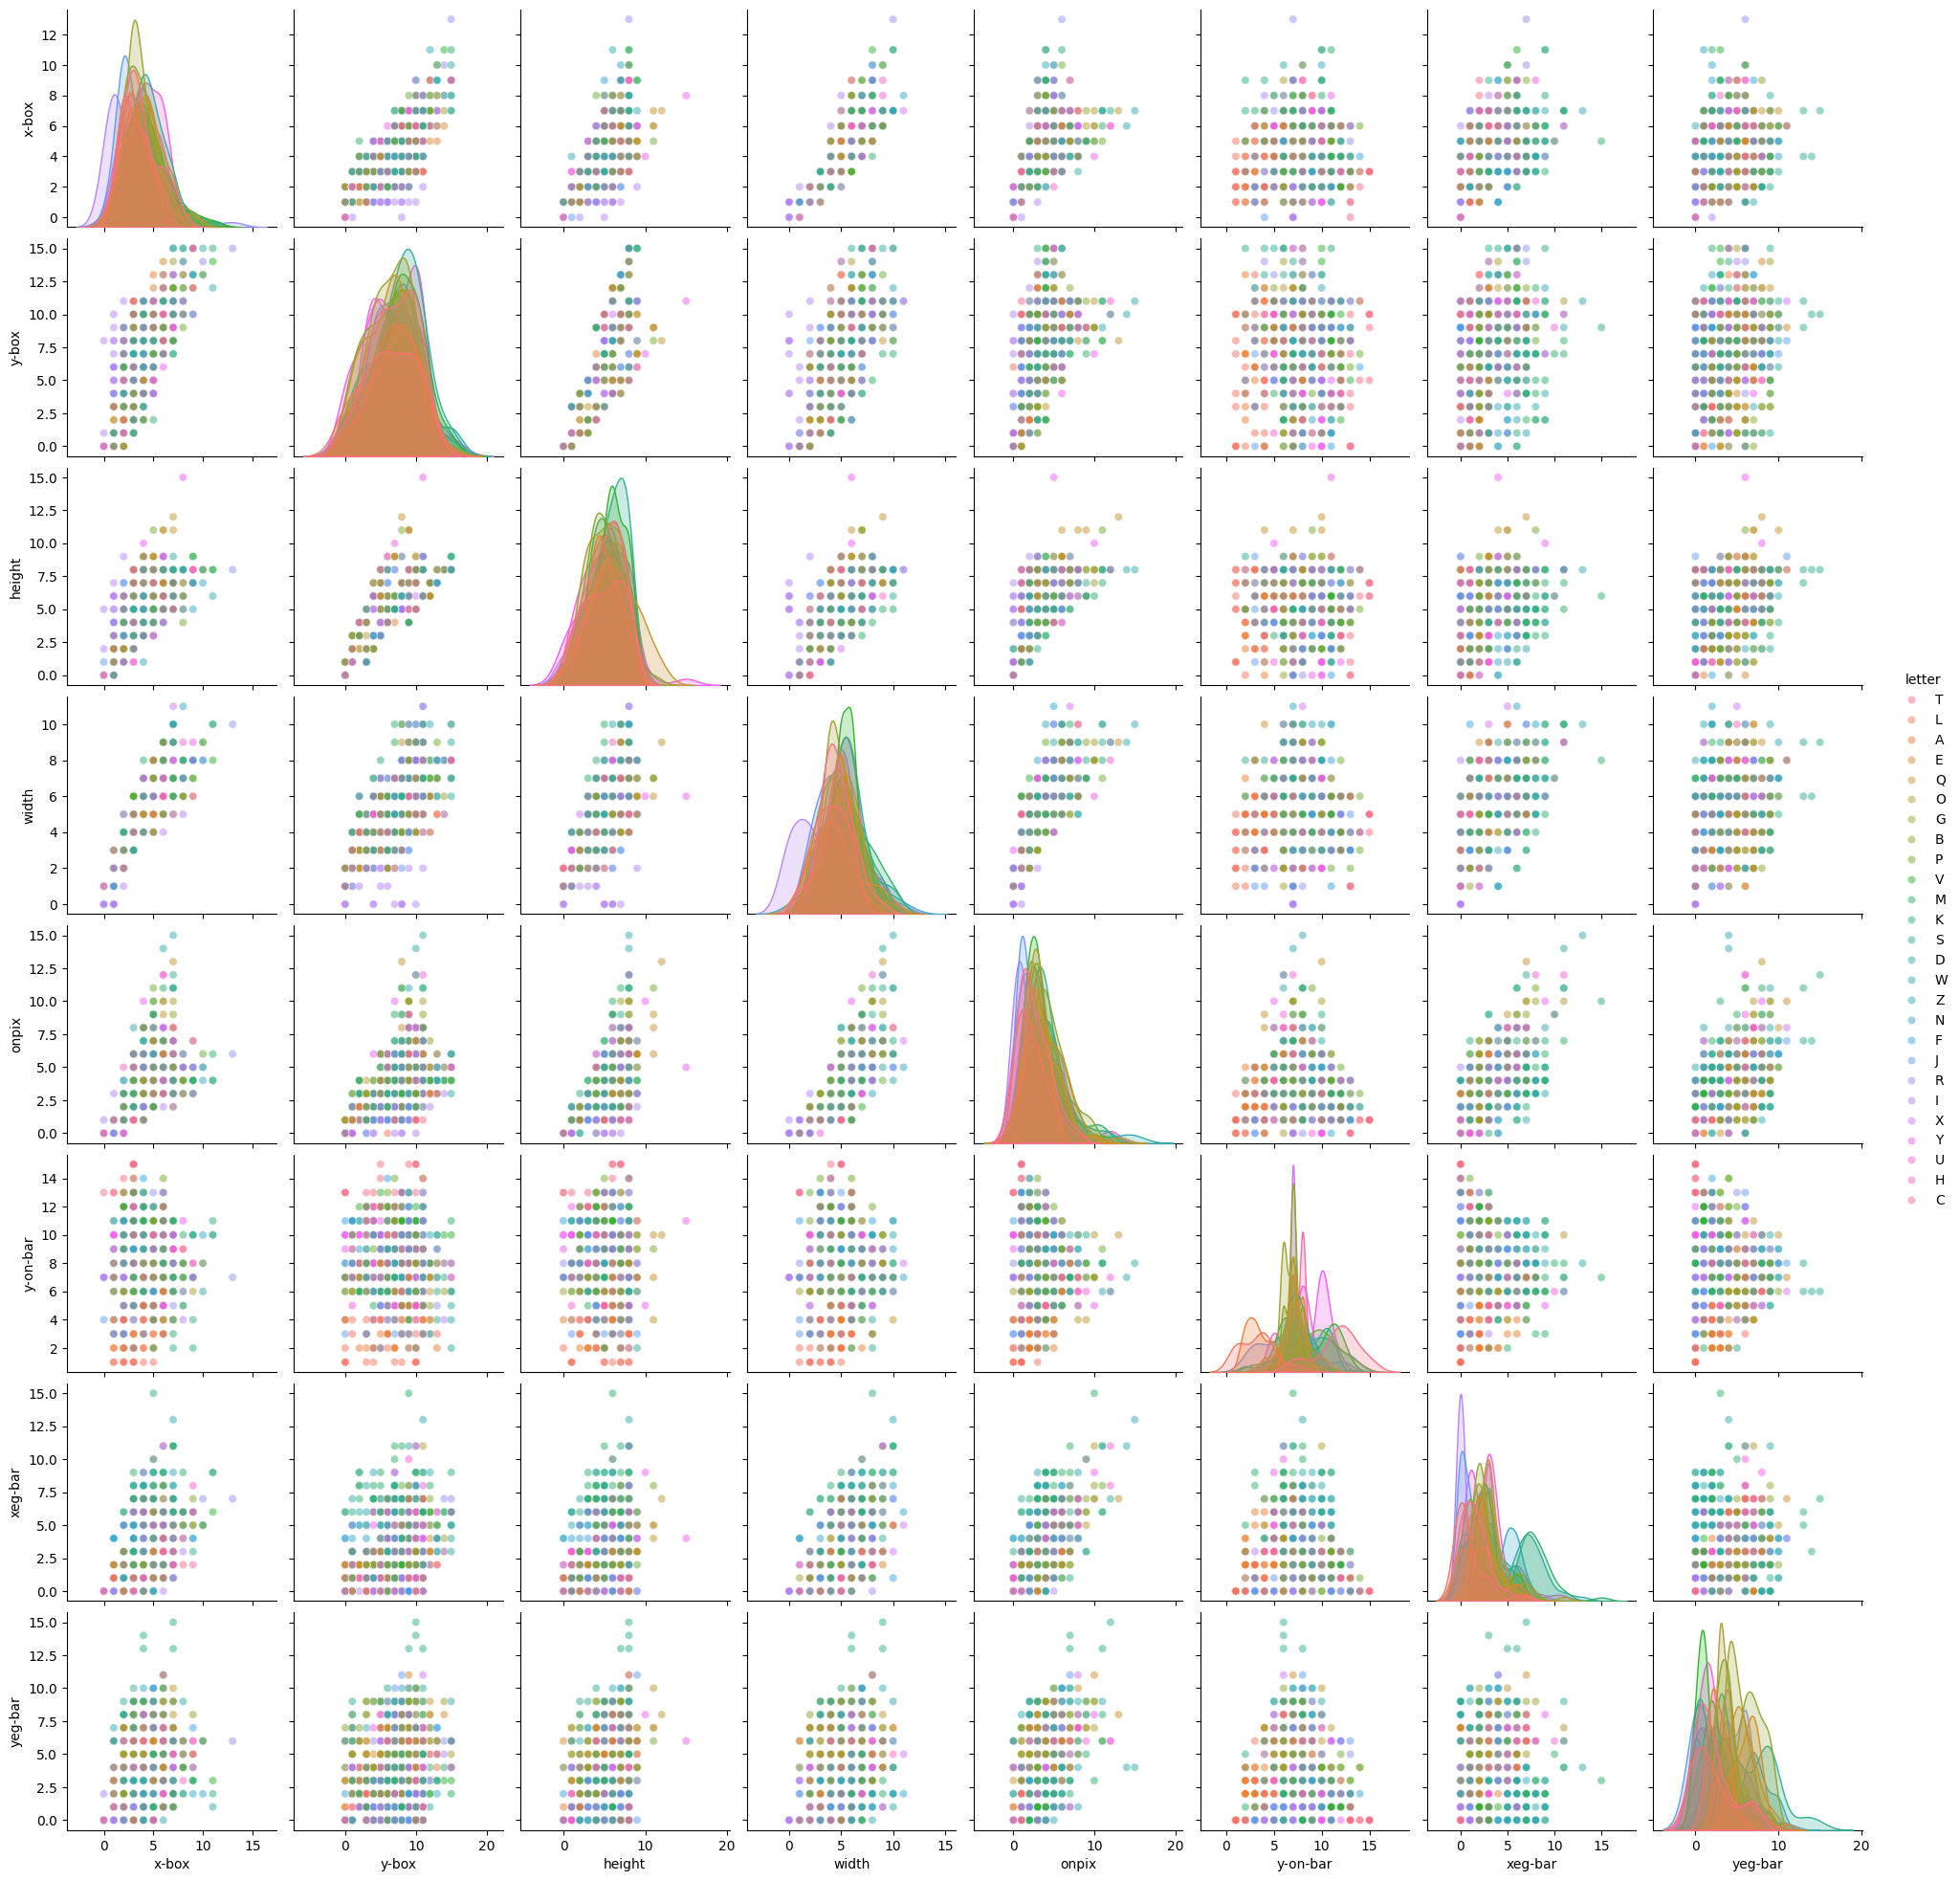

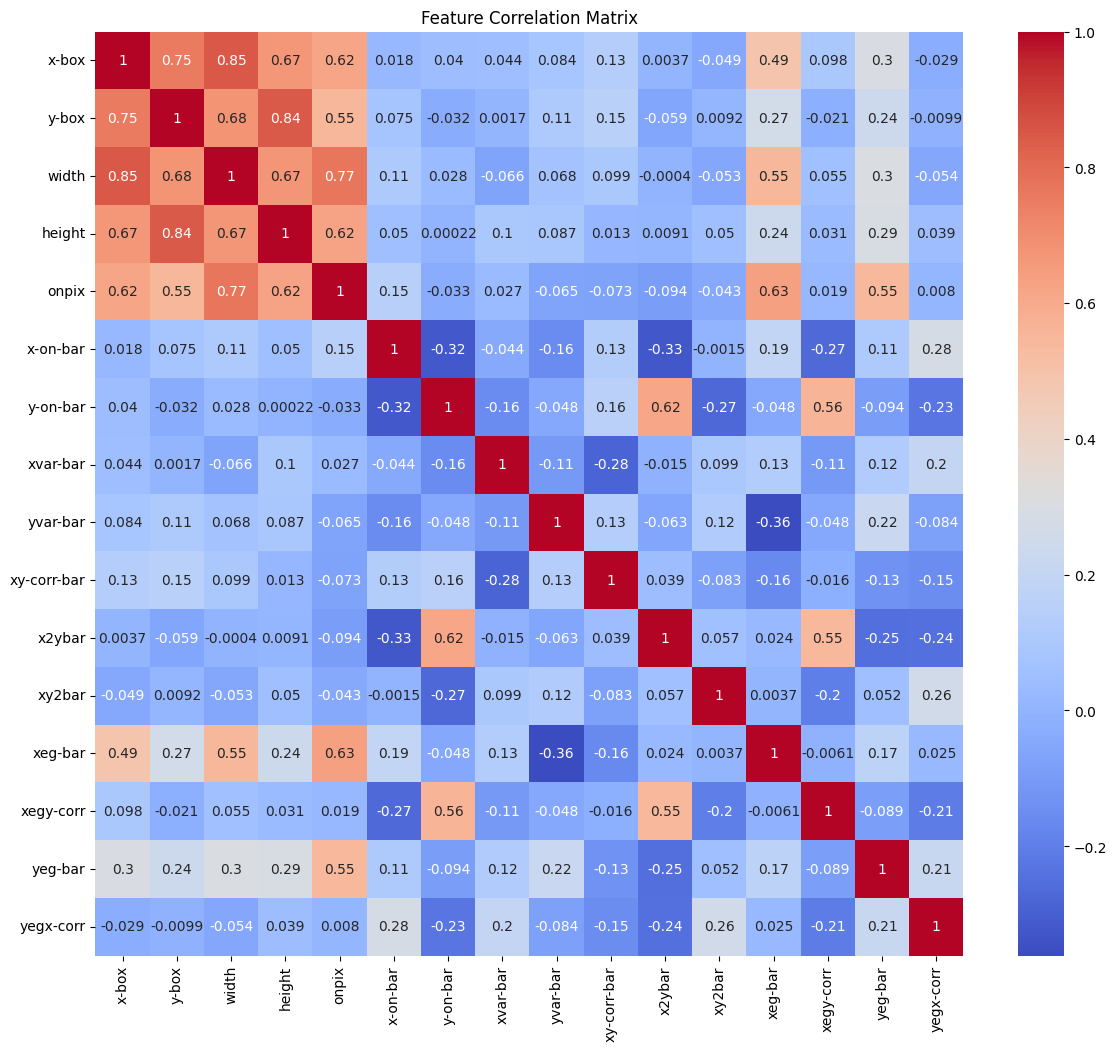

In [ ]:
#Here I'm looking at the relationship between some features

#Plot1
f = ['x-box', 'y-box', 'height', 'width', 'onpix', 'y-on-bar', 'xeg-bar', 'yeg-bar']
sns.pairplot(data_sample[f + ['letter']], hue='letter', diag_kind='kde', plot_kws={'alpha': 0.5})
plt.savefig('pairplot.png')
plt.show()

#Summary plot
plt.figure(figsize=(14, 12))
sns.heatmap(data_sample.drop(columns='letter').corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.savefig('correlation_matrix.png')
plt.show()


Exploring the relationships between features helps us understand how different features relate to each other and potentially influence the classification of letters from A to Z.

The pairplot reveals some moderate linear relationships among certain features.
While there are noticeable correlations, they do not exhibit strong linearity, suggesting that the choice of letter class is likely influenced by a combination of features rather than a single dominant predictor.

However I am noting down the moderate relationships of:

*   the first 5 features with themselves
*   y-on-bar with x2ybar and xegy-corr
*   onpix with xeg-bar and yeg-bar
*   xeg-bar with x-box and width
*   x2ybar with xegy-corr

While some correlations exist, they are not overly strong, affirming the complexity and balanced nature of our multiclass classification problem




#Using Standard Models


---


As shown above in the plot of distribution of the classes of the target feature, the classes are fairly balanced.

As such, accuracy should be a fair metric for the supervised learning models I'll be using to solve this balanced multiclass classification problem.


I'll begin the modeling approach by exploring several standard supervised learning models: K Nearest Neighbors (kNN), Logistic Regression, SGD Classifier, and Decision Trees. Each model will be tuned using cross-validation to find optimal hyperparameters, and finally put the best ones together using ensemble methods.

This dataset comes with a predefined training size. The train set consists of 16,000 samples with the rest used for testing.

In [ ]:
#The website suggests a test size of 0.2 so thats what I'll be using here.

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    shuffle=True,
                                                    random_state=42,
                                                   stratify=y)

kfold = KFold(n_splits=5, shuffle=True, random_state=0)

In [ ]:
#kNN
knn_model = KNeighborsClassifier()

knn_scores = cross_validate(knn_model,
                        X_train, y_train, cv=kfold,
                        return_train_score=True)

knn_train_score = np.mean(knn_scores["train_score"])
knn_train_std = np.std(knn_scores["train_score"])
knn_val_score = np.mean(knn_scores["test_score"])
knn_val_std = np.std(knn_scores["test_score"])
print("Mean Train Score and Std: ", knn_train_score, ", ", knn_train_std)
print("Mean Val Score and Std: ", knn_val_score, ", ",knn_val_std)

Mean Train Score and Std:  0.9712500000000001 ,  0.0013799626353637494
Mean Val Score and Std:  0.94375 ,  0.0021102428770167513


For each sample, the kNN compares its features (like x-box, y-box, width, etc.) to those of other samples in the dataset.

With k=5(as specified by the default knn model), kNN finds the five closest training samples (letters) in terms of feature similarity and predict the new sample as the letter that appears most frequently among these five neighbors.

In [ ]:
#Logistic Regression-multinomial

logreg_model = LogisticRegression(penalty=None, multi_class='multinomial', max_iter=7_000)

logreg_scores = cross_validate(logreg_model,
                        X_train, y_train, cv=kfold,
                        return_train_score=True)

logreg_train_score = np.mean(logreg_scores["train_score"])
logreg_val_score = np.mean(logreg_scores["test_score"])
print("Mean Train Accuracy:", logreg_train_score)
print("Mean Val Accuracy:", logreg_val_score)

logreg_pred_prob = cross_val_predict(logreg_model, X_train, y_train, cv=kfold, method='predict_proba')
logreg_train_loss = log_loss(y_train, logreg_pred_prob)
print()
print("Train Log Loss:", logreg_train_loss)

Mean Train Accuracy: 0.7800312500000001
Mean Val Accuracy: 0.7723125

Train Log Loss: 0.8564704661527556


For each feature (like x-box, y-box, width, etc.), Logistic Regression assigns a weight indicating its importance in predicting the letter class and then computes the probability of each class (letter) given the input features using the softmax function. The model predicts the class with the highest probability for each sample.


In [ ]:
# SGD Logistic Regression-multinomial

sgd_mult_model = SGDSoftmaxClassifier(verbose=1, eta0=0.0011, alpha=0, max_iter=100,
                              early_stopping=True, n_iter_no_change=12,
                              learning_rate='constant', random_state=0)

soft_scores = cross_validate(sgd_mult_model,
                        X_train, y_train, cv=kfold,
                        return_train_score=True)


soft_train_score = np.mean(soft_scores["train_score"])
soft_val_score = np.mean(soft_scores["test_score"])
soft_pred_prob = cross_val_predict(sgd_mult_model, X_train, y_train, cv=kfold, method='predict_proba')
soft_train_loss = log_loss(y_train, soft_pred_prob)
print("Softmax Train Accuracy:", soft_train_score)
print("Softmax Val Accuracy:", soft_val_score)
print("Softmax Log Loss:", soft_train_loss)


epoch 0: STARTING
epoch 0: DONE
Validation loss: 1.406752454214659
Validation accuracy: 0.62265625
epoch 1: STARTING
epoch 1: DONE
Validation loss: 1.2252667949796159
Validation accuracy: 0.67265625
epoch 2: STARTING
epoch 2: DONE
Validation loss: 1.112425223295482
Validation accuracy: 0.70703125
epoch 3: STARTING
epoch 3: DONE
Validation loss: 1.0595697278196812
Validation accuracy: 0.72265625
epoch 4: STARTING
epoch 4: DONE
Validation loss: 1.0494877820827444
Validation accuracy: 0.715625
epoch 5: STARTING
epoch 5: DONE
Validation loss: 1.0175776991633037
Validation accuracy: 0.72109375
epoch 6: STARTING
epoch 6: DONE
Validation loss: 1.0110946462697044
Validation accuracy: 0.7328125
epoch 7: STARTING
epoch 7: DONE
Validation loss: 1.0152868930356058
Validation accuracy: 0.72890625
epoch 8: STARTING
epoch 8: DONE
Validation loss: 1.019556183657557
Validation accuracy: 0.7171875
epoch 9: STARTING
epoch 9: DONE
Validation loss: 0.9845734893111111
Validation accuracy: 0.7359375
epoch 10

Much like in the logistic regression, each feature (e.g., x-box, y-box, width, etc.) is assigned a weight indicating its influence on the prediction. This technique updates model parameters (weights) incrementally using each sample.

The model employs the softmax function to compute probabilities for each class. The class with the highest probability is chosen as the predicted class.

SGD Logistic Regression offers a linear decision boundary, which might not capture the complex patterns in the letter recognition dataset as effectively as non-linear models like kNN.

In [ ]:
# SGD Logistic Regression-OvR

sgd_ovr_model = SGDClassifier(loss='log_loss', penalty=None, learning_rate='adaptive',
                              eta0=0.0095, early_stopping=True,
                              n_iter_no_change=10, verbose=1)

ovr_scores = cross_validate(sgd_ovr_model,
                        X_train, y_train, cv=kfold,
                        return_train_score=True)

ovr_train_score = np.mean(ovr_scores["train_score"])
ovr_val_score = np.mean(ovr_scores["test_score"])
ovr_pred_prob = cross_val_predict(sgd_ovr_model, X_train, y_train, cv=kfold, method='predict_proba')
ovr_train_loss = log_loss(y_train, ovr_pred_prob)
print("OvR Train Accuracy:", ovr_train_score)
print("OvR Val Accuracy:", ovr_val_score)
print("OvR Log Loss:", ovr_train_loss)

Streaming output truncated to the last 5000 lines.
Total training time: 0.06 seconds.
-- Epoch 6
Norm: 2.74, NNZs: 16, Bias: -1.050017, T: 69120, Avg. loss: 0.189098
Total training time: 0.07 seconds.
-- Epoch 7
Norm: 2.71, NNZs: 16, Bias: -1.216248, T: 80640, Avg. loss: 0.194079
Total training time: 0.08 seconds.
-- Epoch 8
Norm: 2.73, NNZs: 16, Bias: -1.373886, T: 92160, Avg. loss: 0.191338
Total training time: 0.10 seconds.
-- Epoch 9
Norm: 2.71, NNZs: 16, Bias: -1.542344, T: 103680, Avg. loss: 0.194425
Total training time: 0.11 seconds.
-- Epoch 10
Norm: 2.64, NNZs: 16, Bias: -1.704508, T: 115200, Avg. loss: 0.197169
Total training time: 0.12 seconds.
-- Epoch 11
Norm: 2.64, NNZs: 16, Bias: -1.858386, T: 126720, Avg. loss: 0.193414
Total training time: 0.13 seconds.
-- Epoch 12
Norm: 2.40, NNZs: 16, Bias: -1.878597, T: 138240, Avg. loss: 0.123994
Total training time: 0.14 seconds.
-- Epoch 13
Norm: 2.23, NNZs: 16, Bias: -1.908770, T: 149760, Avg. loss: 0.118759
Total training time:

The model uses the OvR strategy, where a separate binary classifier is trained for each class. Each classifier distinguishes one class from the rest.

The unregularised logistic regression model seems to not be performing too well, as clearly shown by the quite low accuracy of range 73-77% on the validation set, and a depressingly high log loss of 0.853-0.981.

As such, I am going to apply regularisation and search for an optimum C.

Since the features are already scaled, I wont be doing any scaling of the features..

In [ ]:
#Logistic Regression with 'L2' Regularisation

logreg_model_l2 = LogisticRegression(penalty='l2', max_iter=7_000, multi_class='multinomial', C=1)

param_grid = {'C' : [0.01, 0.1, 1, 10, 100]}

grid_logreg_l2 = GridSearchCV(logreg_model_l2,
                              param_grid=param_grid,
                              scoring=['accuracy', 'neg_log_loss'],
                              refit='neg_log_loss',
                              cv=kfold,
                              return_train_score=True,
                              verbose=3,
                              n_jobs=-1)

grid_logreg_l2.fit(X_train, y_train)
print("L2 Scores and Standard Deviation")
print("Train Accuracy: ", grid_logreg_l2.cv_results_['mean_train_accuracy'], " , ", grid_logreg_l2.cv_results_['std_train_accuracy'])
print("Val Accuracy: ", grid_logreg_l2.cv_results_['mean_test_accuracy'], " , ", grid_logreg_l2.cv_results_['std_test_accuracy'])
print("Train Log loss: ", -grid_logreg_l2.cv_results_['mean_train_neg_log_loss'], " , ", grid_logreg_l2.cv_results_['std_train_neg_log_loss'])
print("Val Log loss: ", -grid_logreg_l2.cv_results_['mean_test_neg_log_loss'], " , ", grid_logreg_l2.cv_results_['std_test_neg_log_loss'])
print("Best C:", grid_logreg_l2.best_params_)


#Logistic Regression with 'L1' Regularisation
logreg_model_l1 = LogisticRegression(penalty='l1', max_iter=7_000, multi_class='multinomial', solver='saga', C=1)

param_grid = {'C' : [0.01, 0.1, 1, 10, 100]}

grid_logreg_l1 = GridSearchCV(logreg_model_l1,
                              param_grid=param_grid,
                              scoring=['accuracy', 'neg_log_loss'],
                              refit='neg_log_loss',
                              cv=kfold,
                              return_train_score=True,
                              verbose=3,
                              n_jobs=-1)

grid_logreg_l1.fit(X_train, y_train)

print()
print("L1 Scores and Standard Deviation")
print("Train Accuracy:  ", grid_logreg_l1.cv_results_['mean_train_accuracy'], " , ", grid_logreg_l1.cv_results_['std_train_accuracy'])
print("Val  Accuracy): ", grid_logreg_l1.cv_results_['mean_test_accuracy'],  " , ", grid_logreg_l1.cv_results_['std_test_accuracy'])
print("Train Log loss: ", -grid_logreg_l1.cv_results_['mean_train_neg_log_loss'],  " , ", grid_logreg_l2.cv_results_['std_train_neg_log_loss'])
print("Val Log loss: ", -grid_logreg_l1.cv_results_['mean_test_neg_log_loss'],  " , ", grid_logreg_l2.cv_results_['std_test_neg_log_loss'])
print("Best C:", grid_logreg_l1.best_params_)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
L2 Scores and Standard Deviation
Train Accuracy:  [0.76259375 0.77810937 0.78028125 0.78004688 0.78014063]  ,  [0.00136341 0.00144512 0.00094088 0.0010265  0.00114223]
Val Accuracy:  [0.75625   0.7705    0.772     0.7721875 0.7723125]  ,  [0.00298433 0.00365291 0.00457831 0.00503115 0.00513338]
Train Log loss:  [0.97234676 0.83500757 0.82269657 0.82243222 0.82242733]  ,  [0.00299263 0.00479142 0.00519304 0.00521261 0.00520838]
Val Log loss:  [0.99016733 0.86291087 0.85575493 0.85634339 0.85640559]  ,  [0.00907332 0.01660747 0.02123414 0.02205775 0.02210893]
Best C: {'C': 1}
Fitting 5 folds for each of 5 candidates, totalling 25 fits

L1 Scores and Standard Deviation
Train Accuracy:   [0.719      0.77535937 0.77726562 0.77720312 0.77723437]  ,  [0.00095862 0.00126707 0.0015625  0.00150714 0.00160154]
Val  Accuracy):  [0.7145625 0.7679375 0.769375  0.7688125 0.7693125]  ,  [0.00494738 0.00322102 0.00416927 0.00496629 0.0047697 ]

Regularization helps to enhance the model performance by reducing overfitting. The optimal regularization strength found for both L1 and L2 is C=1. Overall, L2 regularization shows slightly better performance, but both methods provide significant improvement over the unregularized model.

As we can see above Logistic Regression does not perform too well on this dataset, with the lowest possible validation cross entropy loss we get being 0.856 even with regularization. I did notice however on the website that this is actually the range that the performance  of a Logistic Regression model should achieve on the dataset with accuracy as the metric.


In [ ]:
#Decision Tree

tree_model = DecisionTreeClassifier(max_depth=23, random_state=42)

tree_scores = cross_validate(tree_model,
                        X_train, y_train, cv=5,
                        return_train_score=True)

tree_train_score = np.mean(tree_scores["train_score"])
tree_val_score = np.mean(tree_scores["test_score"])
print("Mean Train Accuracy:", tree_train_score)
print("Mean Val Accuracy:", tree_val_score)

Mean Train Accuracy: 0.9971875000000001
Mean Val Accuracy: 0.8637499999999999


Above we have a fairly good Decision Tree model (which I may have handtuned to achieve this value of validation score).

The high training accuracy indicates that the Decision Tree model fits the training data very well, almost perfectly. However, the validation accuracy is significantly lower, suggesting that the model is overfitting the training data and not generalizing well to unseen data. Clearly we can see that there is some overfitting, which might be reduced later on by bagging.





# Polynomial Features & Standard Models
This section covers the use of Polynomial Features and Principal Component Analysis (PCA) to enhance feature interactions and reduce dimensionality. I will then apply these transformations to the standard models I used earlier, to observe any improvements.

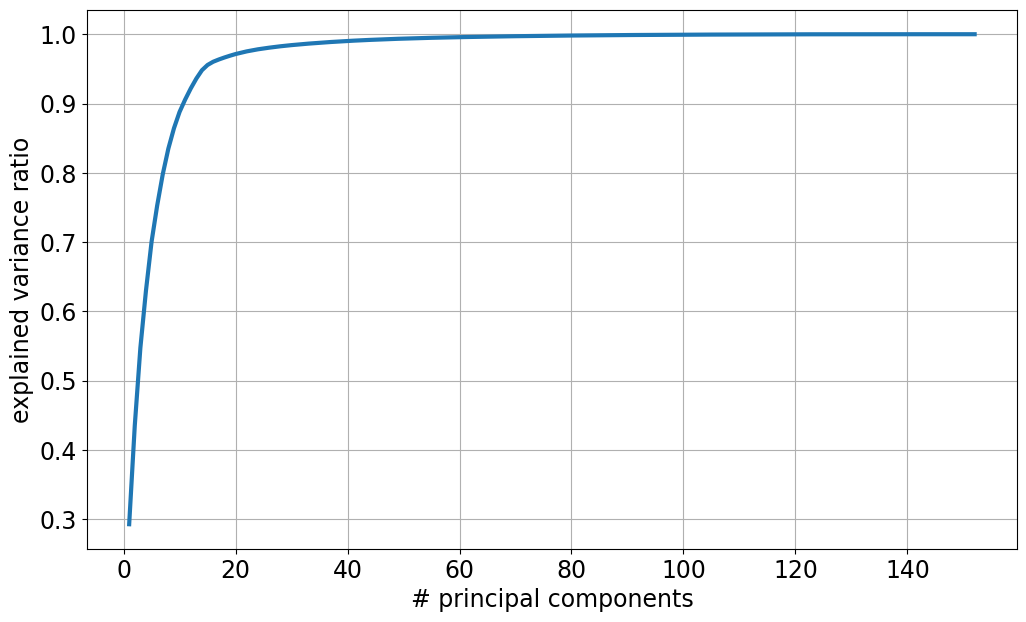

In [ ]:
pca = PCA()
poly_xtrain = PolynomialFeatures(degree=2, include_bias=False).fit_transform(X_train)
pca_xtrain = pca.fit_transform(poly_xtrain)

plt.rcParams.update({'font.size': 17})
plt.rcParams["figure.figsize"] = (12,7)
explained_variance_cumulated = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, 153), explained_variance_cumulated, lw=3)
plt.xlabel("# principal components")
plt.ylabel("explained variance ratio")
plt.grid()
plt.show()

In [ ]:
#PolyxkNN

poly = PolynomialFeatures(degree=2, include_bias=False)
pca = PCA(n_components= 40)
knn_model = KNeighborsClassifier()

knn_pipe = Pipeline([
      ("poly", poly),
      ("pca", pca),
      ("model", knn_model) ])

kfold_s = KFold(n_splits=3, shuffle=True, random_state=0)

poly_knn_scores = cross_validate(knn_pipe,
                          X_train, y_train,
                          cv=kfold_s,
                           n_jobs=-1,
                          return_train_score=True)

print("Train and test accuracy:", np.mean(poly_knn_scores["train_score"]),
      " , ", np.mean(poly_knn_scores["test_score"]))

Train and test accuracy: 0.9631249686769996  ,  0.9288124916318705


In [ ]:
#Polyxlogreg unregularised

logreg_model = LogisticRegression(penalty=None, multi_class='multinomial', max_iter=7_000)

logreg_pipe = Pipeline([
      ("poly", poly),
      ("pca", pca),
      ("model", logreg_model)
      ])

poly_logreg_scores = cross_validate(logreg_pipe,
                          X_train, y_train,
                          cv=kfold_s,
                          scoring = ['accuracy', 'neg_log_loss'],
                           n_jobs=-1,
                          return_train_score=True)

print("Train and test accuracy:", np.mean(poly_logreg_scores["train_accuracy"]),
      " , ", np.mean(poly_logreg_scores["test_accuracy"]))
print("Train and test Log Loss:", np.mean(-poly_logreg_scores["train_neg_log_loss"]),
      " , ", np.mean(-poly_logreg_scores["test_neg_log_loss"]))

Train and test accuracy: 0.8747499060024335  ,  0.8461871550698953
Train and test Log Loss: 0.43003432230090466  ,  0.5435272492817218


These results show a significant improvement over the previous unregularized logistic regression model (which had validation accuracy around 73-77%).

The model shows a good balance between train and test accuracy, indicating that the model generalizes fairly well. However, the log loss indicates that there might be room for improvement, as the prediction probabilities are not as confident as desired.

In [ ]:
#PolyxTree
tree_pipe = Pipeline([
      ("poly", poly),
      ("pca", pca),
      ("model", tree_model) ])

poly_tree_scores = cross_validate(tree_pipe,
                          X_train, y_train,
                          cv=kfold_s,
                           n_jobs=-1,
                          return_train_score=True)

print("Train and test accuracy:", np.mean(poly_tree_scores["train_score"]),
      " , ", np.mean(poly_tree_scores["test_score"]))

Train and test accuracy: 0.988625021462829  ,  0.7468128456566218


The decision tree model showed very high accuracy on the training data, but significantly lower accuracy on the test data, indicating a high level of overfitting(higher than before polynomial features were applied). This suggests that while decision trees can fit the training data very well, they may not generalize as effectively without additional regularization or ensemble techniques.

In [ ]:
#PolyxSGD-OvR
ovr_pipe = Pipeline([
      ("poly", poly),
      ("pca", pca),
      ("model", sgd_ovr_model) ])

poly_ovr_scores = cross_validate(ovr_pipe,
                          X_train, y_train,
                          cv=kfold_s,
                           n_jobs=-1,
                          return_train_score=True)

print("Train and test accuracy:", np.mean(poly_ovr_scores["train_score"]),
      " , ", np.mean(poly_ovr_scores["test_score"]))

Train and test accuracy: 0.8190624498403514  ,  0.7996874125030264


In the 2 sections above , I trained some simple and standard models on the dataset (sometimes tuning hyperparameters to achieve a better score).

Overall, the performances on the features given as they were are:

*   K-Nearest Neighbours with Accuracy: 0.971 and 0.944
*   Logistic Regression with Accuracy: 0.780 and 0.772
*   SGD OvR Classifier with Accuracy: 0.713 and 0.705
*   SGD Softmax Classifier with Accuracy: 0.748 and 0.736
*   Decision Tree with Accuracy: 0.997 and 0.864

After performing some feature engineering with degree at most 2 on the some of these models, these were the achieved performances:

*   K-Nearest Neighbours with Accuracy:  0.963  ,  0.929
*   Logistic Regression with Accuracy:   0.875 ,  0.846
*   SGD OvR Classifier with Accuracy:    0.819  ,  0.7997
*   Decision Tree with Accuracy:         0.989  ,  0.747


Next Steps:
1.   Drop SGD OvR classifier due to its low performance even after feature engineering
2.   Apply (L1, L2) regularization  to Logistic Regression to control overfitting and improve generalization of the logistic regression models.
3.   Perform hyperparameter tuning for kNN, logistic regression and decision tree to find optimal settings.
4.   Explore ensemble methods like Random Forests or Gradient Boosting for the decision tree model to mitigate overfitting and potentially improve test accuracy.




# Tuning Standard Models

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    shuffle=True,
                                                    random_state=42,
                                                   stratify=y)

kfold = KFold(n_splits=5, shuffle=True, random_state=0)
kfold_s = KFold(n_splits=3, shuffle=True, random_state=0)
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
          'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

In [ ]:
#kNN

knn_model = KNeighborsClassifier()

param_grid = {'n_neighbors' : np.arange(1, 16, 2)}

best_knn = GridSearchCV(knn_model, param_grid=param_grid,
                        cv=kfold, verbose=1)

best_knn.fit(X_train, y_train)
print("Best K:", best_knn.best_params_)
print(best_knn.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best K: {'n_neighbors': 1}
0.9516875


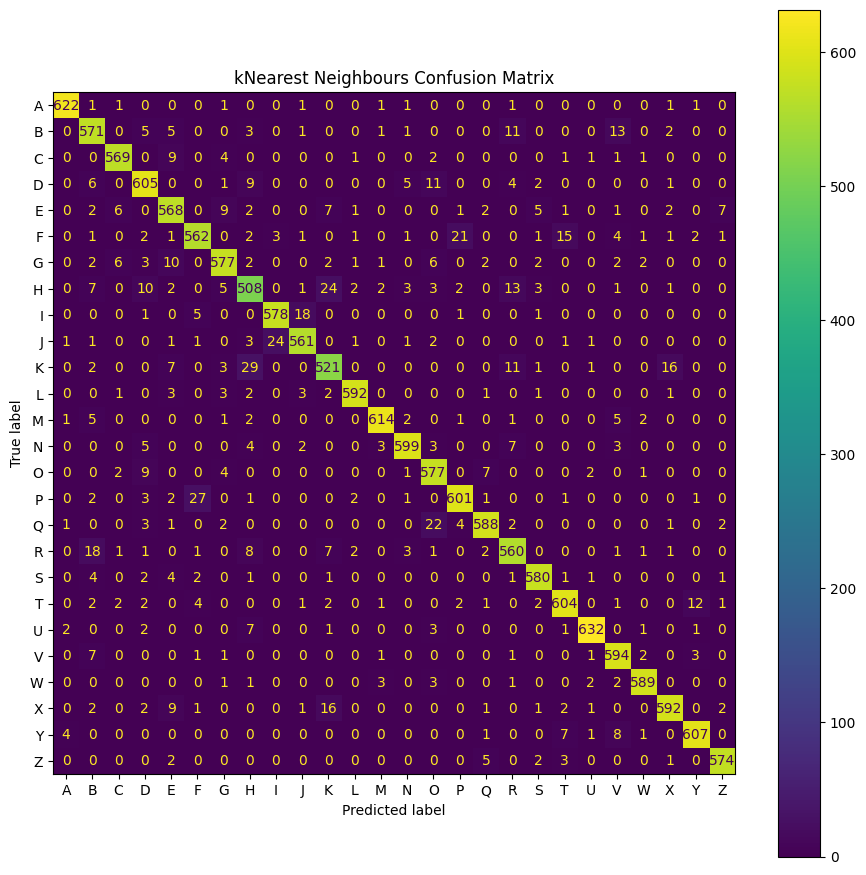

In [ ]:
knn_pred = cross_val_predict(best_knn.best_estimator_, X_train, y_train, cv=kfold_s)

knn_cm = confusion_matrix(y_train, knn_pred)

fig, ax = plt.subplots(figsize=(11, 11))
disp= ConfusionMatrixDisplay(confusion_matrix=knn_cm,
                                     display_labels= labels)
disp.plot(ax=ax)
plt.title("kNearest Neighbours Confusion Matrix")
plt.show()

Letters like 'A', 'C', 'L', 'M', and 'W' are classified well by the model.
Misclassifications: There are several pairs where the model tends to confuse one letter for another. For example:

'K' is often predicted as 'X'.

'I' is frequently predicted as 'J'.

'F' is predicted as 'P' and vice versa.

'R' is predicted as 'B'.

These observations suggest that the model may struggle with distinguishing certain letters that share similar features or shapes. This could be due to the inherent similarities in the visual representation of these letters or the features used by the model to make predictions.

Maybe a better performance can be achieved by, combining multiple kNN models or different classifiers to leverage their strengths and mitigate weaknesses, especially in distinguishing similar classes.


In [ ]:
#LogReg l2

poly = PolynomialFeatures(degree=2, include_bias=False)
pca = PCA(n_components= 40)

logreg_l2_pipe = Pipeline([
      ("poly", poly),
      ("pca", pca),
      ("model", LogisticRegression(C=1, random_state=0, max_iter=5_000,
                                   multi_class='multinomial', n_jobs=-1))
      ])

param_grid = {'model__C' : [0.01, 0.1, 1, 10, 100]}

best_logreg_l2 = GridSearchCV(logreg_l2_pipe, param_grid=param_grid,
                              scoring=['accuracy', 'neg_log_loss'],
                              refit='neg_log_loss', cv=kfold, verbose=1)
best_logreg_l2.fit(X_train, y_train)

print("Best C:", best_logreg_l2.best_params_)
print()
print(best_logreg_l2.best_score_)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best C: {'model__C': 0.01}

-0.5193107649326087


In [ ]:
#LogReg l1

logreg_l1_pipe = Pipeline([
      ("poly", poly),
      ("pca", pca),
      ("model", LogisticRegression(penalty='l1', C=1,
                                   random_state=0, max_iter=5_000,
                                   solver='saga', multi_class='multinomial',
                                   n_jobs=-1))
      ])

param_grid = {'model__C' : [0.01, 0.1, 1, 10, 100]}

best_logreg_l1 = GridSearchCV(logreg_l1_pipe, param_grid=param_grid,
                              scoring=['accuracy', 'neg_log_loss'],
                              refit='neg_log_loss', cv=kfold, verbose=1)
best_logreg_l1.fit(X_train, y_train)

print("Best C:", best_logreg_l1.best_params_)
print()
print(-best_logreg_l1.best_score_)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best C: {'model__C': 0.1}

0.5342757450794526


Both L2 and L1 regularized logistic regression models achieved improvements in log loss compared to the unregularized model with feature engineering (which had a log loss of approximately 0.544).

The C found for L2 regularization was 0.01, while for L1 regularization, it was 0.1.

These values indicate how much regularization is applied, with lower values suggesting stronger regularization

Since the lowest cross entropy score we've achieved so far was from l2 regularisation, we will be working with that moving forward.


In [ ]:
#LogReg l2 cont

poly = PolynomialFeatures(degree=2, include_bias=False)
pca = PCA(n_components= 40)

logreg_l2_pipe = Pipeline([
      ("poly", poly),
      ("pca", pca),
      ("model", LogisticRegression(C=1, random_state=0, max_iter=5_000,
                                   multi_class='multinomial', n_jobs=-1))
      ])

param_grid = {'model__C' : np.linspace(0.001, 0.015, num=10)}

best_logreg_l2 = GridSearchCV(logreg_l2_pipe, param_grid=param_grid,
                              scoring='neg_log_loss',
                              cv=kfold, verbose=1)
best_logreg_l2.fit(X_train, y_train)

print("Best C:", best_logreg_l2.best_params_)
print()
print(-best_logreg_l2.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best C: {'model__C': 0.01188888888888889}

0.5182033099545826


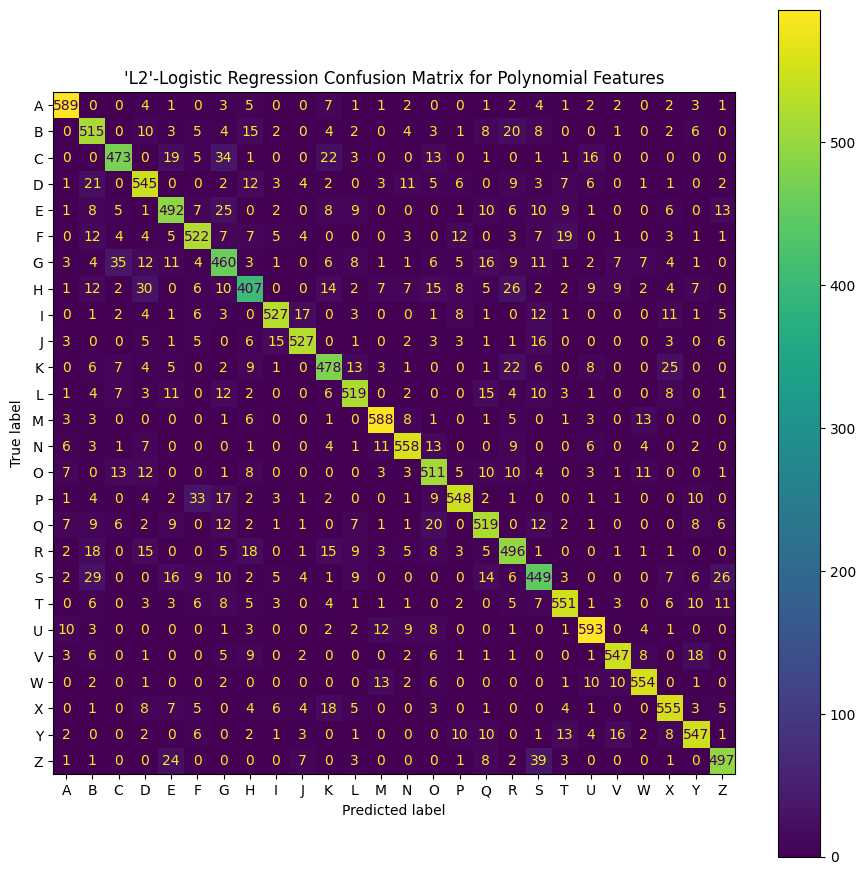

In [ ]:
# Analysing best logreg model

logreg_pred = cross_val_predict(best_logreg_l2.best_estimator_, X_train, y_train, cv=kfold_s)

logreg_cm = confusion_matrix(y_train, logreg_pred)

fig, ax = plt.subplots(figsize=(11, 11))
disp= ConfusionMatrixDisplay(confusion_matrix=logreg_cm,
                                     display_labels= labels)
disp.plot(ax=ax)
plt.title("'L2'-Logistic Regression Confusion Matrix for Polynomial Features")
plt.show()

Here we can see that even though the Logistic Regression model has a better accuracy with polynomial features.'A' is the only letter it seems to classify well enough.
However, there are still misclassifications evident across multiple letters, indicating areas where the model struggles to distinguish between similar classes.

In [ ]:
#Decision Tree

tree_model = DecisionTreeClassifier(random_state=42)

param_grid = {"criterion":['gini', 'entropy'],
              "max_depth": np.arange(5, 25, 2)}

best_tree = GridSearchCV(tree_model, param_grid,
                        cv=kfold, n_jobs=-1, verbose=2)
best_tree.fit(X_train, y_train)

print("Best Params:", best_tree.best_params_)
print("Best Score:", best_tree.best_score_)



Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Params: {'criterion': 'entropy', 'max_depth': 17}
Best Score: 0.8686250000000001


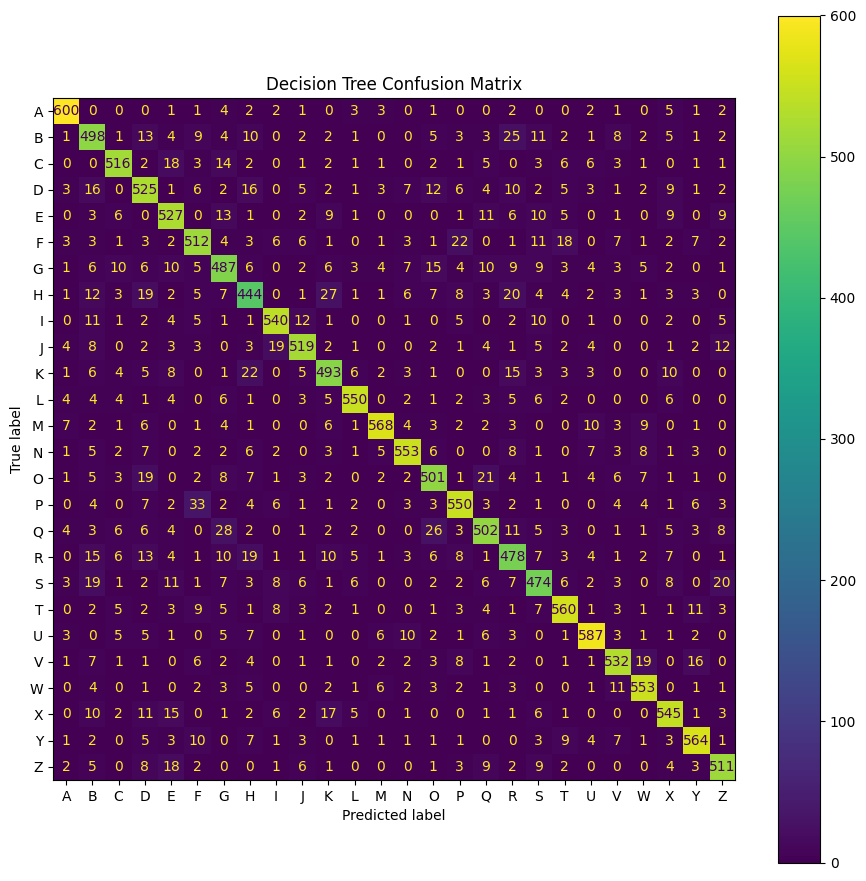

In [ ]:
# Analysing the tree model

tree_pred = cross_val_predict(best_tree.best_estimator_, X_train, y_train, cv=kfold_s)

tree_cm = confusion_matrix(y_train, tree_pred)

fig, ax = plt.subplots(figsize=(11, 11))
disp= ConfusionMatrixDisplay(confusion_matrix=tree_cm,
                                     display_labels= labels)
disp.plot(ax=ax)
plt.title("Decision Tree Confusion Matrix")
plt.show()

From the above Confusion Matrix, we can see that the Decision Tree model performs slightly better than logistic regression but worse than the kNearest Neighbours model. Here we have the model not performing as badly on 'I' as the kNN model, but performing worse than kNN with regards to 'B', 'C', 'D', 'O', 'S', 'V' and 'Z'.
However the model performs fairly well with 'A's and 'L's.

# Ensemble Methods

In this section, I will be doing some ensemble learning. With bagging and then gradient boosting. Inferring from what I have above, the models the learnt to cater best to the goal of the project were the KNN model and the Decision tree(albeit the overfitting on the single tree). I'll be dropping the logistic regression model from henceforth, since it's only good on 'A' and the other models are also good at predicting 'A's.

In [ ]:
#initialising best models
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    shuffle=True,
                                                    random_state=42,
                                                   stratify=y)

kfold = KFold(n_splits=5, shuffle=True, random_state=0)
kfold_s = KFold(n_splits=3, shuffle=True, random_state=0)
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
          'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


knn = KNeighborsClassifier(n_neighbors=1)
tree = DecisionTreeClassifier(criterion='entropy', max_depth=17, random_state=42)

In [ ]:
forest = RandomForestClassifier(n_estimators=100,
                                n_jobs=-1,
                                random_state=42)

param_grid = {"n_estimators": [250, 350, 400],
              "max_depth": np.arange(5, 27, 3),
              "max_features": np.arange(2, 10, 2)}

forest_cv = RandomizedSearchCV(forest, param_grid,
                        cv=kfold_s, n_iter= 60, n_jobs=-1, verbose=2)
forest_cv.fit(X_train, y_train)

print("Best Params:", forest_cv.best_params_)
print("Best Score:", forest_cv.best_score_)
print("Mean test Accuracy:", forest_cv.cv_results_['mean_test_score'])

Fitting 3 folds for each of 60 candidates, totalling 180 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Params: {'n_estimators': 350, 'max_features': 4, 'max_depth': 23}
Best Score: 0.9538749762036355
Mean test Accuracy: [0.88618784 0.94512496 0.61700007 0.95018753 0.61706262 0.92218749
 0.94812499 0.79193805 0.94374996 0.94606263 0.8876876  0.94693749
 0.92706253 0.95200013 0.95387498 0.86875009 0.94987495 0.94862498
 0.93075003 0.9518125  0.95162496 0.75825012 0.95212505 0.93943755
 0.94587516 0.94000008 0.95243756 0.66081309 0.79656318 0.92737491
 0.94931247 0.67831271 0.94875    0.88681283 0.92262504 0.95306257
 0.79200056 0.94906254 0.94843748 0.94600023 0.9525001  0.95337499
 0.92681247 0.86962519 0.77943788 0.94631267 0.94499988 0.94431241
 0.79731311 0.94506258 0.77956292 0.87812544 0.88781279 0.95068751
 0.94974993 0.94981246 0.92887498 0.95318744 0.78018796 0.9315    ]


In [ ]:
#ExtraTrees

extratrees = ExtraTreesClassifier(n_estimators=250,
                              n_jobs=-1,
                              random_state=42)

param_grid = {"n_estimators": [250, 350, 400],
              "max_depth": np.arange(5, 26, 4),
              "max_features": np.arange(2, 10, 2)}

extratrees_cv = RandomizedSearchCV(forest, param_grid,
                        cv=kfold_s, n_iter= 60, n_jobs=-1, verbose=2)

extratrees_cv.fit(X_train, y_train)

print("Best Params:", extratrees_cv.best_params_)
print("Best Score:", extratrees_cv.best_score_)
print("Mean test Accuracy:", extratrees_cv.cv_results_['mean_test_score'])

Fitting 3 folds for each of 60 candidates, totalling 180 fits
Best Params: {'n_estimators': 400, 'max_features': 2, 'max_depth': 25}
Best Score: 0.9528750543159417
Mean test Accuracy: [0.81843749 0.83343761 0.90962522 0.94499988 0.93956255 0.95237508
 0.95068753 0.63743781 0.94825002 0.67925021 0.94568761 0.94550006
 0.91031267 0.95218755 0.94000008 0.61700007 0.83162521 0.94850003
 0.95162501 0.9181251  0.94374996 0.63843788 0.95187502 0.91768758
 0.8320003  0.95225002 0.9454375  0.92162487 0.94575016 0.92000009
 0.93943755 0.92093752 0.66381315 0.81950005 0.9103126  0.95012512
 0.94693749 0.94587511 0.80587515 0.67831271 0.83356267 0.83268767
 0.94568766 0.91662504 0.94650002 0.94900009 0.94368741 0.94587514
 0.80687524 0.67781256 0.94512496 0.92118737 0.61718758 0.66325054
 0.95287505 0.95131261 0.95268754 0.94431241 0.95237512 0.95050002]


Here it looks like the Random Forest model performs better than the Extra Trees model. So, moving forward, I'll just stick to the Random Forest since, the extra randomness from the extra trees model seems to not have much of an effect.

In [ ]:
#Bagging with KNN

bagger = BaggingClassifier(estimator= knn,
                           n_estimators=150,
                          bootstrap_features=True,
                          n_jobs=-1, random_state=0, verbose=2)

param_grid = {"max_samples": np.arange(40, 3100, 300),
              "max_features": np.arange(2, 17, 2)}

knn_bagger = RandomizedSearchCV(bagger, param_grid,
                        cv=kfold_s, n_iter= 100, n_jobs=-1, verbose=2)
knn_bagger.fit(X_train, y_train)

print("Best Params:", knn_bagger.best_params_)
print("Best Score:", knn_bagger.best_score_)
print("Mean test Accuracy:", knn_bagger.cv_results_['mean_test_score'])

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 88 is smaller than n_iter=100. Running 88 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 88 candidates, totalling 264 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Best Params: {'max_samples': 3040, 'max_features': 16}
Best Score: 0.9513749839961173
Mean test Accuracy: [0.54724878 0.64668727 0.65662441 0.65906167 0.65168679 0.65037427
 0.66168688 0.66624968 0.65812477 0.66381225 0.66706202 0.67274929
 0.82250012 0.84493759 0.85468771 0.86243783 0.86506289 0.87318794
 0.87356281 0.87556301 0.87618792 0.87850061 0.69181211 0.86631263
 0.89281274 0.90375034 0.90931273 0.91443782 0.91800032 0.91987532
 0.92075025 0.92412527 0.92425005 0.70493701 0.88200026 0.90825035
 0.91906253 0.92450013 0.92937521 0.93287514 0.93543766 0.93668766
 0.9390626  0.94031255 0.69899979 0.89081262 0.91606262 0.92637505
 0.9335002  0.93868765 0.94037507 0.9421875  0.9440001  0.94612498
 0.94731244 0.69300022 0.89125023 0.91843779 0.93062523 0.9373752
 0.94056266 0.94218761 0.9448126  0.94762503 0.94900001 0.95031251
 0.68956231 0.89231269 0.91843777 0.92862523 0.9360626  0.94000018
 0.94206265 0.94443751 0.94681243 0.94924997 0.95049995 0.68974951
 0.89256284 0.9196252  0

[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.0s finished


In [ ]:
#HistogramGradientBoost

histboost = HistGradientBoostingClassifier(max_iter=200,
                                           random_state=42,
                                           verbose=1)

param_grid = {"max_leaf_nodes": [150, 250, 350, 450],
              "min_samples_leaf": [20, 30, 40, 50],
              "max_depth": np.arange(1, 6),
              "learning_rate": [ 0.01, 0.1, 1.0]}

histboost_cv = RandomizedSearchCV(histboost, param_grid,
                        cv=kfold_s, n_iter= 100, n_jobs=-1, verbose=1)
histboost_cv.fit(X_train, y_train)

print("Best Params:", histboost_cv.best_params_)
print("Best Score:", histboost_cv.best_score_)
print("Mean test Accuracy:", histboost_cv.cv_results_['mean_test_score'])

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Binning 0.002 GB of training data: 0.202 s
Binning 0.000 GB of validation data: 0.153 s
Fitting gradient boosted rounds:
[1/200] 26 trees, 554 leaves (21 on avg), max depth = 5, train loss: 1.92635, val loss: 1.96791, in 0.932s
[2/200] 26 trees, 680 leaves (26 on avg), max depth = 5, train loss: 1.61235, val loss: 1.66540, in 0.496s
[3/200] 26 trees, 690 leaves (26 on avg), max depth = 5, train loss: 1.40195, val loss: 1.46034, in 0.466s
[4/200] 26 trees, 711 leaves (27 on avg), max depth = 5, train loss: 1.23840, val loss: 1.30162, in 0.517s
[5/200] 26 trees, 705 leaves (27 on avg), max depth = 5, train loss: 1.10526, val loss: 1.17048, in 0.479s
[6/200] 26 trees, 709 leaves (27 on avg), max depth = 5, train loss: 0.99675, val loss: 1.06370, in 2.119s
[7/200] 26 trees, 722 leaves (27 on avg), max depth = 5, train loss: 0.90343, val loss: 0.97125, in 0.142s
[8/200] 26 trees, 715 leaves (27 on avg), max depth = 5, train loss

In [ ]:
#AdaBoost

depth3 = DecisionTreeClassifier(max_depth=3)
depth7 = DecisionTreeClassifier(max_depth=7)
depth5 = DecisionTreeClassifier(max_depth=5)

adaboost = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                         random_state=42)

param_grid = {"estimator": [depth7, depth5, depth3],
              "learning_rate": [0.7, 0.85, 0.9],
              "n_estimators": [300, 350]}

ada_cv= RandomizedSearchCV(adaboost, param_grid,
                        cv=kfold_s, n_iter= 15, n_jobs=-1, verbose=2)
ada_cv.fit(X_train, y_train)

print("Best Params:", ada_cv.best_params_)
print("Best Score:", ada_cv.best_score_)
print("Mean test Accuracy:", ada_cv.cv_results_['mean_test_score'])


Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best Params: {'n_estimators': 350, 'learning_rate': 0.85, 'estimator': DecisionTreeClassifier(max_depth=7)}
Best Score: 0.9348123979346009
Mean test Accuracy: [0.88368769 0.93374983 0.87806248 0.73199998 0.93162476 0.9348124
 0.75643737 0.88231251 0.73475063 0.88412526 0.75243737 0.88400024
 0.87912526 0.72581234 0.93268744]


#Voting Classifier

In this section I want to try leveraging the strengths of each model using a Voting Classifier model to hopefully balance out the performance of the individual ensemble methods.

In [ ]:
#model initialization
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    shuffle=True,
                                                    random_state=42,
                                                   stratify=y)

kfold = KFold(n_splits=5, shuffle=True, random_state=0)
kfold_s = KFold(n_splits=3, shuffle=True, random_state=0)
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
          'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

knn = KNeighborsClassifier(n_neighbors=1)
forest = RandomForestClassifier(n_estimators=350, max_features=4, max_depth=23, n_jobs=-1, random_state=42)
knn_bagger = BaggingClassifier(estimator= knn, n_estimators=150, max_features=4, max_samples=3040,
                               bootstrap_features=True,  n_jobs=-1, random_state=0, verbose=2)
histboost = HistGradientBoostingClassifier(max_iter=200, learning_rate=0.1, max_leaf_nodes=350, min_samples_leaf=30,
                                           max_depth=5, random_state=42, verbose=2)
adaboost = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=7),
                         n_estimators=350, learning_rate=0.85, random_state=42)

In [ ]:
#Voting Classifier- bagger

voteclf_bag_hard =  VotingClassifier(estimators=[('forest', forest),
                                          ('bagger', knn_bagger)],
                                     n_jobs=-1)

voteclf_bag_soft= VotingClassifier(estimators=[('forest', forest),
                                          ('bagger', knn_bagger)],
                               voting='soft', n_jobs=-1)

bag_hard_scores = cross_validate(voteclf_bag_hard,
                          X_train, y_train,
                          cv=kfold_s,
                          n_jobs=-1)
bag_soft_scores = cross_validate(voteclf_bag_soft,
                          X_train, y_train,
                          cv=kfold_s,
                          n_jobs=-1)

print("Score with Hard Voting: ", np.mean(bag_hard_scores["test_score"]))
print("Standard Deviation of Hard Voting Score: ", np.std(bag_hard_scores["test_score"]))
print()
print("Score with Soft Voting: ", np.mean(bag_soft_scores["test_score"]))
print("Standard Deviation of Soft Voting Score: ", np.std(bag_soft_scores["test_score"]))

Score with Hard Voting:  0.913937651661909
Standard Deviation of Hard Voting Score:  0.0020646295117572955

Score with Soft Voting:  0.9506250074262939
Standard Deviation of Soft Voting Score:  0.0035223637843534534


The soft voting approach significantly outperforms hard voting, although its higher standard deviation indicates more consistent performance across folds for hard voting.
This however suggests that combining Bagging with KNN and Random Forest using soft voting can effectively leverage their individual strengths and generalize well on unseen data.

In [ ]:
#Voting Classifier- boost

voteclf_boost_hard =  VotingClassifier(estimators=[('Histgradboost', histboost),
                                          ('Adaboost', adaboost)],
                                     n_jobs=-1)

voteclf_boost_soft= VotingClassifier(estimators=[('Histgradboost', histboost),
                                          ('Adaboost', adaboost)],
                               voting='soft', n_jobs=-1)

boost_hard_scores = cross_validate(voteclf_boost_hard,
                          X_train, y_train,
                          cv=kfold_s,
                          n_jobs=-1)
boost_soft_scores = cross_validate(voteclf_boost_soft,
                          X_train, y_train,
                          cv=kfold_s,
                          n_jobs=-1)

print("Score with Hard Voting: ", np.mean(boost_hard_scores["test_score"]))
print("Standard Deviation of Hard Voting Score: ", np.std(boost_hard_scores["test_score"]))
print()
print("Score with Soft Voting: ", np.mean(boost_soft_scores["test_score"]))
print("Standard Deviation of Soft Voting Score: ", np.std(boost_soft_scores["test_score"]))

Score with Hard Voting:  0.9389998550012488
Standard Deviation of Hard Voting Score:  0.004661613763701148

Score with Soft Voting:  0.9529374176062232
Standard Deviation of Soft Voting Score:  0.002981852639742065


Soft voting again shows higher mean score and slightly lower standard deviation compared to hard voting.
This indicates that combining Histogram Gradient Boosting and AdaBoost through soft voting leads to robust performance and better generalization.

In [ ]:
#Voting Classifier-All

voteclf_all_hard =  VotingClassifier(estimators=[('Histgradboost', histboost),
                                          ('Adaboost', adaboost),
                                                   ('forest', forest),
                                          ('bagger', knn_bagger)],
                                     n_jobs=-1)

voteclf_all_soft= VotingClassifier(estimators=[('Histgradboost', histboost),
                                          ('Adaboost', adaboost),
                                                 ('forest', forest),
                                          ('bagger', knn_bagger)],
                               voting='soft', n_jobs=-1)

all_hard_scores = cross_validate(voteclf_all_hard,
                          X_train, y_train,
                          cv=kfold_s,
                          n_jobs=-1)
all_soft_scores = cross_validate(voteclf_all_soft,
                          X_train, y_train,
                          cv=kfold_s,
                          n_jobs=-1)

print("Score with Hard Voting: ", np.mean(all_hard_scores["test_score"]))
print("Standard Deviation of Hard Voting Score: ", np.std(all_hard_scores["test_score"]))
print()
print("Score with Soft Voting: ", np.mean(all_soft_scores["test_score"]))
print("Standard Deviation of Soft Voting Score: ", np.std(all_soft_scores["test_score"]))

Score with Hard Voting:  0.9501874449267814
Standard Deviation of Hard Voting Score:  0.0032749749947365014

Score with Soft Voting:  0.9547499840224828
Standard Deviation of Soft Voting Score:  0.0033731059984328593


# Finding a Final Model

Across all configurations, soft voting consistently outperformed hard voting, emphasizing the benefit of aggregating probabilistic predictions rather than a majority vote count.

The voting classifier combining all models (Bagging, Random Forest, Histogram Gradient Boosting, and AdaBoost) using soft voting achieved the highest mean score of approximately 95.39% with a standard deviation of about 0.0035, indicating good performance and consistency across cross-validation folds.

However, I think the random forest model performs equally as well on the data set as the voting classifier. So in this section, I want to evaluate the performance of both models on the test set before making a conclusion.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    shuffle=True,
                                                    random_state=42,
                                                   stratify=y)

kfold = KFold(n_splits=5, shuffle=True, random_state=0)
kfold_s = KFold(n_splits=3, shuffle=True, random_state=0)
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
          'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

knn = KNeighborsClassifier(n_neighbors=1)
forest = RandomForestClassifier(n_estimators=350, max_features=4, max_depth=23, n_jobs=-1, random_state=42)
knn_bagger = BaggingClassifier(estimator= knn, n_estimators=150, max_features=4, max_samples=3040,
                               bootstrap_features=True,  n_jobs=-1, random_state=0, verbose=2)
histboost = HistGradientBoostingClassifier(max_iter=200, learning_rate=0.1, max_leaf_nodes=350, min_samples_leaf=30,
                                           max_depth=5, random_state=42, verbose=2)
adaboost = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=7),
                         n_estimators=350, learning_rate=0.85, random_state=42)
votingclf = VotingClassifier(estimators=[('Histgradboost', histboost),
                                          ('Adaboost', adaboost),
                                                   ('forest', forest),
                                          ('bagger', knn_bagger)],
                               voting='soft', n_jobs=-1)

votingclf.fit(X_train, y_train)

VotingClassifier(estimators=[('Histgradboost',
                              HistGradientBoostingClassifier(max_depth=5,
                                                             max_iter=200,
                                                             max_leaf_nodes=350,
                                                             min_samples_leaf=30,
                                                             random_state=42,
                                                             verbose=2)),
                             ('Adaboost',
                              AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=7),
                                                 learning_rate=0.85,
                                                 n_estimators=350,
                                                 random_state=42)),
                             ('forest',
                              RandomForestClassifier(max_depth=23,
                                                     max_features=4,
                                                     n_estimators=350,
                                                     n_jobs=-1,
                                                     random_state=42)),
                             ('bagger',
                              BaggingClassifier(bootstrap_features=True,
                                                estimator=KNeighborsClassifier(n_neighbors=1),
                                                max_features=4,
                                                max_samples=3040,
                                                n_estimators=150, n_jobs=-1,
                                                random_state=0, verbose=2))],
                 n_jobs=-1, voting='soft')

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    4.4s finished


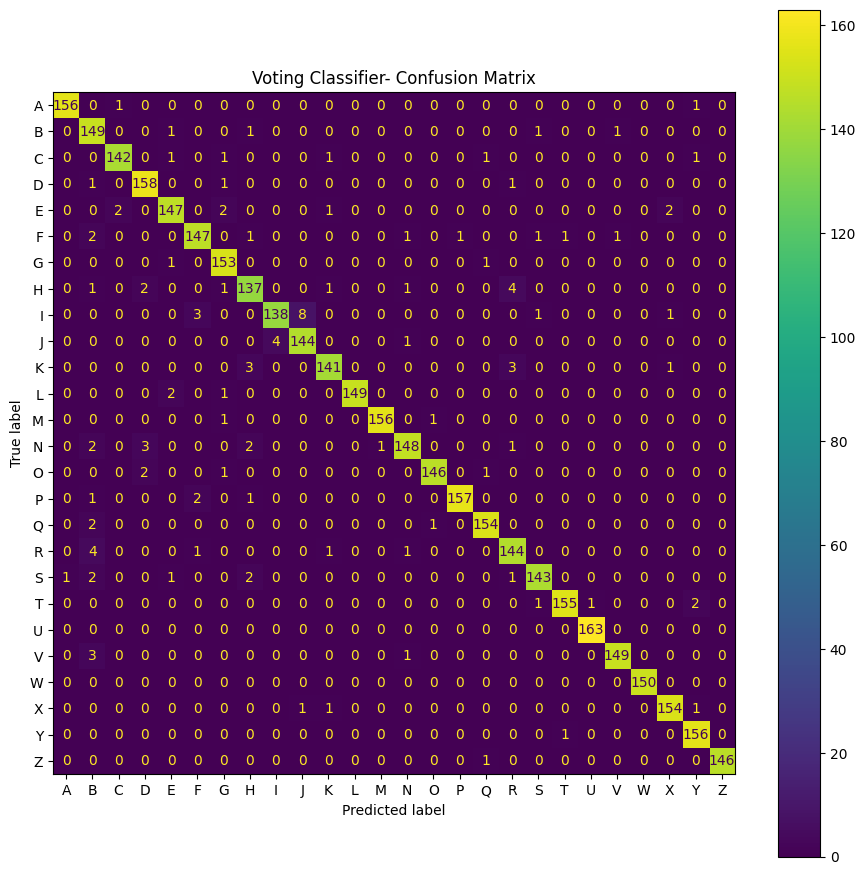

In [ ]:
#confusion matrix voting classifier

votingclf_pred = votingclf.predict(X_test)

votingclf_cm = confusion_matrix(y_test, votingclf_pred)

fig, ax = plt.subplots(figsize=(11, 11))
disp= ConfusionMatrixDisplay(confusion_matrix=votingclf_cm,
                                     display_labels= labels)
disp.plot(ax=ax)
plt.title("Voting Classifier- Confusion Matrix")
plt.show()

In [ ]:
#classification report- voting classifier

from sklearn.metrics import classification_report

print(classification_report(y_test, votingclf_pred))

              precision    recall  f1-score   support

           A       0.99      0.99      0.99       158
           B       0.89      0.97      0.93       153
           C       0.98      0.97      0.97       147
           D       0.96      0.98      0.97       161
           E       0.96      0.95      0.96       154
           F       0.96      0.95      0.95       155
           G       0.95      0.99      0.97       155
           H       0.93      0.93      0.93       147
           I       0.97      0.91      0.94       151
           J       0.94      0.97      0.95       149
           K       0.97      0.95      0.96       148
           L       1.00      0.98      0.99       152
           M       0.99      0.99      0.99       158
           N       0.97      0.94      0.95       157
           O       0.99      0.97      0.98       150
           P       0.99      0.98      0.98       161
           Q       0.97      0.98      0.98       157
           R       0.94    

Classes like 'A', 'L', 'M', 'U', and 'W' have very high precision and recall scores (close to or at 1.00), suggesting that the model performs exceptionally well for these classes.
Classes like 'B', 'C', 'H', 'I', and 'R' have slightly lower precision and recall compared to the top-performing classes, but still within a very good range (above 0.90).

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


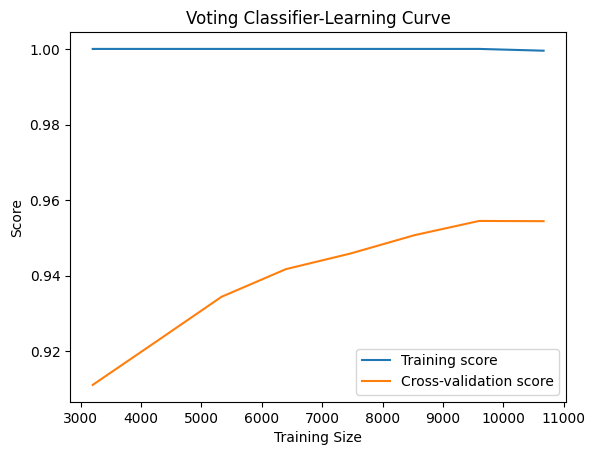

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(votingclf, X_train, y_train, cv=kfold_s, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Voting Classifier-Learning Curve')
plt.legend(loc='best')
plt.savefig('learning_curve.png')
plt.show()

The training score is consistently high and close to 1.0. This indicates that the model is fitting the training data very well, suggesting that it is not underfitting the training data.

The cross-validation score starts lower but gradually increases as the training size increases, eventually leveling off. This upward trend indicates that the model's generalization performance improves with more training data. As the training size reaches the higher end (around 10,000 to 11,000), the cross-validation score appears to converge to a value just around 0.96.
This means that increasing training size beyound this doesn't improve anything much.

The high training score coupled with a lower cross-validation score suggests potential overfitting. The model may be capturing noise in the training data, leading to high performance on training data but not as high on validation data.

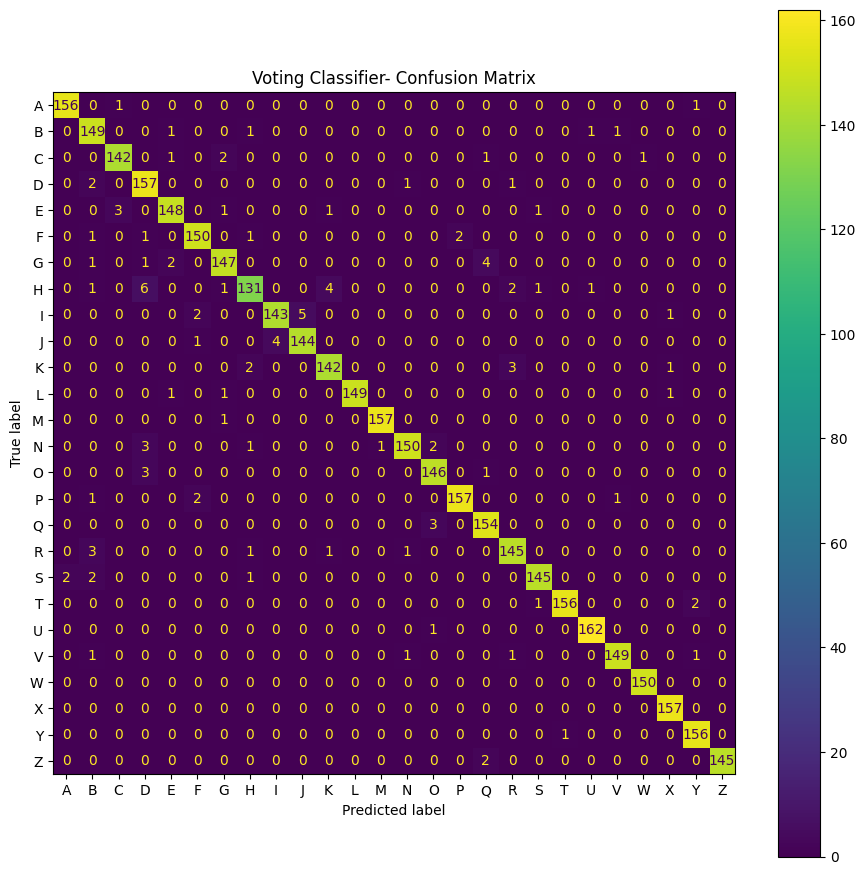

In [ ]:
#confusion matrix-forest

forest.fit(X_train, y_train)
forest_pred = forest.predict(X_test)

forest_cm = confusion_matrix(y_test, forest_pred)

fig, ax = plt.subplots(figsize=(11, 11))
disp= ConfusionMatrixDisplay(confusion_matrix=forest_cm,
                                     display_labels= labels)
disp.plot(ax=ax)
plt.title("Voting Classifier- Confusion Matrix")
plt.show()

In [ ]:
#classification report- random forest

from sklearn.metrics import classification_report

print(classification_report(y_test, forest_pred))

              precision    recall  f1-score   support

           A       0.99      0.99      0.99       158
           B       0.93      0.97      0.95       153
           C       0.97      0.97      0.97       147
           D       0.92      0.98      0.95       161
           E       0.97      0.96      0.96       154
           F       0.97      0.97      0.97       155
           G       0.96      0.95      0.95       155
           H       0.95      0.89      0.92       147
           I       0.97      0.95      0.96       151
           J       0.97      0.97      0.97       149
           K       0.96      0.96      0.96       148
           L       1.00      0.98      0.99       152
           M       0.99      0.99      0.99       158
           N       0.98      0.96      0.97       157
           O       0.96      0.97      0.97       150
           P       0.99      0.98      0.98       161
           Q       0.95      0.98      0.97       157
           R       0.95    


The model performs very well across most classes with high precision, recall, and F1-score.
Classes L, U, W, and Z have perfect scores (100%) across precision, recall, and F1-score, suggesting the model's predictions for these classes were consistently accurate.
The lowest scores (92%) are for precision, recall, and F1-score for class D, indicating it had relatively more false positives and false negatives compared to other classes.


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


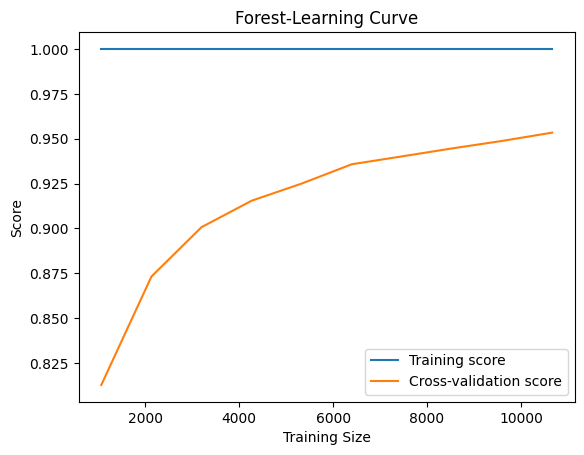

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(forest, X_train, y_train, cv=kfold_s, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Forest-Learning Curve')
plt.legend(loc='best')
plt.show()

Once again we have the training score being consistently high and close to 1.0. This indicates that the model is fitting the training data very well, suggesting that it is not underfitting the training data.

The high training score coupled with a lower cross-validation score suggests potential overfitting.


The cross-validation score starts lower but gradually increases as the training size increases. This upward trend indicates that the model's generalization performance improves with more training data. However the curve shows that the performance of the model can increase, given more training samples.


#Conclusion

The voting classifier ensemble, comprising Bagging with KNN, Random Forest, Histogram Gradient Boosting, and AdaBoost, achieves strong performance with a mean accuracy of 95.47% on the training data. The final model achieved an overall accuracy of 97% on the test set, indicating that it correctly predicted the class for 97 out of every 100 instances. While the random forest had a mean accuracy of 95.39% on the train data, and 97% on the test set as well.

Overall we see that both models perform quite well on the test set, and are in fact perfect with 'U' and 'W', but the performance on letters like 'B', 'H', 'I', 'N' and 'R' need to be further investigated.

The soft voting strategy proves effective in combining the strengths of individual models, resulting in robust predictions and high accuracy across different classes.

Overall, both models demonstrate high accuracy with minimal misclassifications, as evidenced by the diagonal dominance and low off-diagonal values.

However as shown by the learning curves there is slight overfitting occuring, meanwhile the performance of the voting classifier doesn't increase given more data to train while the random forest model may have more rooom for improvement.

Given that both models perform similarly in terms of accuracy and other metrics, the choice of the final model can be influenced by other considerations.

Random Forests provide feature importances, which can be useful for understanding which features are most influential in the predictions.
It is also more computational efficient due to its single-model nature.
Random Forests are also known for their robustness to noisy data, while Voting Classifiers can sometimes amplify noise from individual models.

For next steps, the random forest model could be revisitied with more training data by data augmentation and more extensive hyperparameter tuning. One could revisit feature importance and consider alternative feature selection techniques to identify the most influential features, or engineer new features that could capture more relevant patterns in your data. One could deploy neural network or XGBoost models or try logistic regression with polynomial features of higher degrees.

        feature  importance
12      xeg-bar    0.118115
14      yeg-bar    0.100941
8      yvar-bar    0.092831
11       xy2bar    0.084624
7      xvar-bar    0.084558
10       x2ybar    0.083019
13    xegy-corr    0.074454
9   xy-corr-bar    0.072888
6      y-on-bar    0.067524
15    yegx-corr    0.054505
5      x-on-bar    0.051537
4         onpix    0.026416
1         y-box    0.024989
2         width    0.022106
0         x-box    0.021412
3        height    0.020081


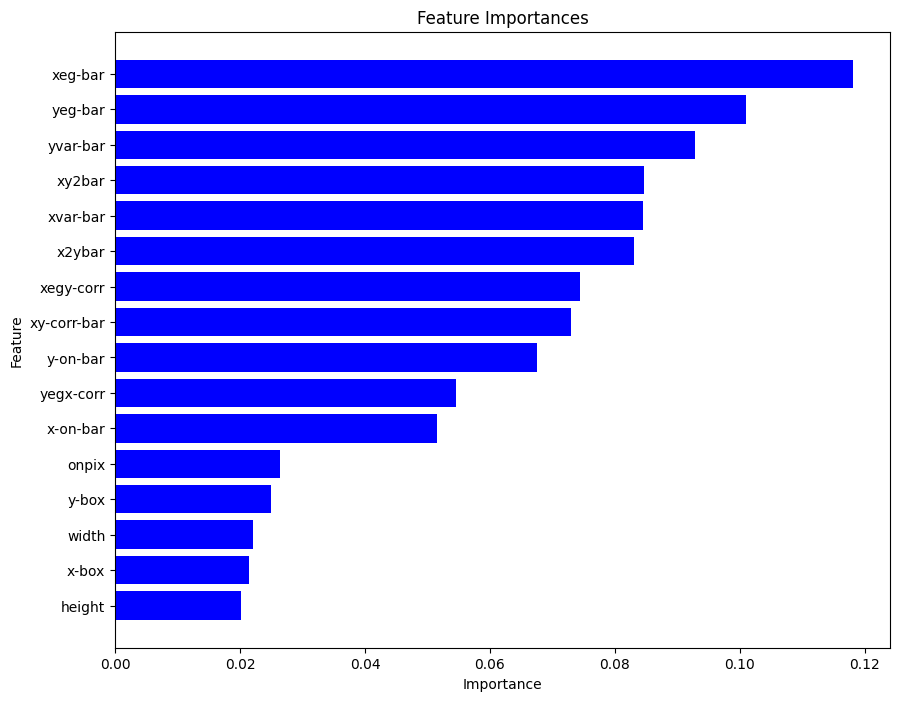

In [ ]:
#feature importances for Random Forest

importances = forest.feature_importances_
feature_names = columns[1:]
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=False)
print(feature_importances)

plt.figure(figsize=(10, 8))
plt.barh(feature_importances['feature'], feature_importances['importance'], color='b', align='center')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()


*   xeg-bar (0.118115) and yeg-bar (0.100941):

*   yvar-bar (0.092831) and xvar-bar (0.084558):

These features rank third and fifth in importance, respectively. They indicate the variance of y and x coordinates among pixels belonging to the same character image. High variance might suggest important spatial patterns or characteristics.

*   xy2bar (0.084624) and x2ybar (0.083019):

These features capture aspects of the relationship between x and y coordinates of adjacent pixels within the same character image. They are crucial in determining the spatial orientation or alignment of pixels, which seems to be significant in the dataset.
*   xegy-corr (0.074454) and xy-corr-bar (0.072888):

These features measure correlations between x and y coordinates or other aspects of the character image. High correlation values indicate strong relationships between these aspects, which the model finds useful for prediction.

*   y-on-bar (0.067524) and yegx-corr (0.054505):

These features also play significant roles, albeit slightly less than the top ones. They likely capture additional spatial or relational information between y coordinates and other characteristics of the character image.

Given the importance of these features, we could consider exploring if additional derived features or transformations could better capture underlying patterns in the data. Since these features are highly ranked, focusing on optimizing their representation or ensuring their quality in the dataset could potentially improve model accuracy further.